## **Algoritmos de Predição Aplicados a Dados de Vendas** 
--------------------------------------------------------------------------------
###### @**Equipe: Francisco Douglas, Rogério Fernandes, Rafael Omega**.
  
- **1**: Dicionário dos Dados  
- **2**: Integração das bases de Dados  
- **3**: Pré-processamento dos dados  
- **4**: Tratamento e Manipulação dos Dados
- **5**: Analise dos Dados Pré-Processados
- **6**: Processamento Final
- **7**: Extração de Insights
- **8**: Modelos Series Temporais

## Importação das Bibliotecas

In [1]:
# Import Das Bibliotecas
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

import plotly.graph_objects as go
import plotly.offline       as py
import plotly.express       as px
import scipy.stats          as stats

import statsmodels.tsa.stattools
from   matplotlib.pylab                   import rcParams
from   pandas_profiling                   import ProfileReport
from   sklearn.metrics                    import mean_absolute_error
from   sklearn.metrics                    import mean_squared_error
from   statsmodels.tsa.seasonal           import seasonal_decompose
from   statsmodels.graphics.tsaplots      import plot_acf, plot_pacf
from   statsmodels.tsa.arima.model        import ARIMA
from   pmdarima.arima                     import auto_arima
from   statsmodels.tsa.statespace.sarimax import SARIMAX
from   scipy.special                      import boxcox, inv_boxcox
from   scipy.stats                        import boxcox
from   sklearn.metrics                    import mean_absolute_percentage_error

sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 10,5

## Integração das Bases de Dados

In [2]:
# Importação das Bases de Dados
vendas       = pd.read_csv('dados_vendas.csv', sep=',', low_memory=False)
clientes     = pd.read_excel('clientes_vendedores.xlsm', sheet_name='CLIENTES')

## Pre-processamento dos dados

In [3]:
# Cabeçalho das bases de dados
display(vendas.head(3))
display(clientes.head(3))

COD_VENDA  SAT_NUMERO  COD_CLIENTE  COD_VENDEDOR        DATA      HORA  \
0   218562.0         NaN          2.0        2734.0  2017-03-17  09:22:40   
1   218632.0         NaN          2.0        2734.0  2017-03-17  09:22:41   
2   809262.0         NaN          2.0        3640.0  2017-09-04  17:27:30   

  COD_PRODUTO                                  DESC_PRODUTO  QTD  PRECO_CUSTO  \
0       42562  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
1       42562  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
2       59933             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   

   CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO  
0        13.99        14.00       14.00  
1        13.99        14.00       14.00  
2        10.84        10.85       10.85

COD_CLIENTE      CLIENTE  EMAIL    SETOR                         ENDERECO  \
0            2  CLIENTE - 2    NaN  SETOR 2  RUA ANTONIO FERREIRA DE ALMEIDA   
1            4  CLIENTE - 4    NaN  SETOR 2             RUA SETE DE SETEMBRO   
2            6  CLIENTE - 6    NaN  SETOR 2                        PRIMAVERA   

  NUMERO COMPLEMENTO        BAIRRO       CEP        MUNICIPIO  UF  
0    333         NaN        CENTRO  12980000       JOANOPOLIS  SP  
1    244      SALA 5        CENTRO  12970000         PIRACAIA  SP  
2    790         NaN  VILA BELMIRA  07863090  FRANCO DA ROCHA  SP

In [4]:
# Shape das Bases de dados
print(f'Base de Vendas: {vendas.shape[0]} Linhas e {vendas.shape[1]} Colunas')
print(f'Base de Clientes: {clientes.shape[0]} Linhas e {clientes.shape[1]} Colunas')

Base de Vendas: 1106185 Linhas e 13 Colunas
Base de Clientes: 6028 Linhas e 11 Colunas


### Merge das Bases de Dados

In [5]:
# Colunas de Vendas
print("Colunas de Vendas: ",vendas.columns,'\n')
print("Colunas de Clientes: ", clientes.columns, '\n')

Colunas de Vendas:  Index(['COD_VENDA', 'SAT_NUMERO', 'COD_CLIENTE', 'COD_VENDEDOR', 'DATA',
       'HORA', 'COD_PRODUTO', 'DESC_PRODUTO', 'QTD', 'PRECO_CUSTO',
       'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO'],
      dtype='object') 

Colunas de Clientes:  Index(['COD_CLIENTE', 'CLIENTE', 'EMAIL', 'SETOR', 'ENDERECO', 'NUMERO',
       'COMPLEMENTO', 'BAIRRO', 'CEP', 'MUNICIPIO', 'UF'],
      dtype='object') 



#### Merge dos dados

In [6]:
# Merge dos Dados, Utilizando apenas as colunas que iremos trabalha
df_vendas = pd.merge(vendas[['COD_VENDA', 'SAT_NUMERO', 'COD_CLIENTE', 'COD_VENDEDOR', 'DATA', 'HORA', 
                             'COD_PRODUTO','QTD', 'PRECO_CUSTO', 'CUSTO_TOTAL','VR_UNITARIO', 'VR_LIQUIDO']],
                   clientes[['COD_CLIENTE', 'SETOR', 'MUNICIPIO', 'UF']],
                   on='COD_CLIENTE', how='outer')
df_vendas.head()

COD_VENDA  SAT_NUMERO  COD_CLIENTE  COD_VENDEDOR        DATA      HORA  \
0   218562.0         NaN          2.0        2734.0  2017-03-17  09:22:40   
1   218632.0         NaN          2.0        2734.0  2017-03-17  09:22:41   
2   809262.0         NaN          2.0        3640.0  2017-09-04  17:27:30   
3   809402.0         NaN          2.0        3640.0  2017-09-04  17:27:31   
4   920012.0         NaN          2.0        3640.0  2017-10-04  16:15:14   

  COD_PRODUTO  QTD  PRECO_CUSTO  CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO  \
0       42562  1.0        13.99        13.99        14.00       14.00   
1       42562  1.0        13.99        13.99        14.00       14.00   
2       59933  1.0        10.84        10.84        10.85       10.85   
3       59933  1.0        10.84        10.84        10.85       10.85   
4       59933  1.0        10.84        10.84        15.19       15.19   

     SETOR   MUNICIPIO  UF  
0  SETOR 2  JOANOPOLIS  SP  
1  SETOR 2  JOANOPOLIS  SP  
2  SETOR 2  JOANOPOLIS  SP  
3  SETOR 2  JOANOPOLIS  SP  
4  SETOR 2  JOANOPOLIS  SP

In [7]:
# Informações sobre os dados
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110655 entries, 0 to 1110654
Data columns (total 15 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   COD_VENDA     1091788 non-null  float64
 1   SAT_NUMERO    204706 non-null   float64
 2   COD_CLIENTE   1096258 non-null  float64
 3   COD_VENDEDOR  1091788 non-null  float64
 4   DATA          1091788 non-null  object 
 5   HORA          1091788 non-null  object 
 6   COD_PRODUTO   1106185 non-null  object 
 7   QTD           1091788 non-null  float64
 8   PRECO_CUSTO   1091788 non-null  float64
 9   CUSTO_TOTAL   1091788 non-null  float64
 10  VR_UNITARIO   1091788 non-null  float64
 11  VR_LIQUIDO    1091788 non-null  float64
 12  SETOR         1096187 non-null  object 
 13  MUNICIPIO     1095407 non-null  object 
 14  UF            1094392 non-null  object 
dtypes: float64(9), object(6)
memory usage: 135.6+ MB


## Analise Exploratoria: Utilizando o Pandas Profiling

In [8]:
# Import da biblioteca
from pandas_profiling import ProfileReport

In [9]:
# Criando o Relatorio
#relatorio_vendas = ProfileReport(df_vendas, title='Relatorio de Vendas')
#relatorio_vendas.to_file('Relatorio_vendas.html')
#relatorio_vendas

##### Logo no Inicio com o Pandas-Profiling percebemos algums valores zeros e uma coluna com mais de 80% de NaN

**DF_VENDAS**
   **Colunas**
   - **SAT_NUMERO**: Quantidade NaN 81.6%
   - **PRECO_CUSTO**: Valores Negativos e Valores Zeros
   - **CUSTO_TOTAL**: Valores Negativos e Valores Zeros
   - **DEMAIS COLUNAS**: Valores NaN 18867

**Plot Grafico dos Dados NaN**

In [10]:
# Grafico Analise de Dados NaN
df = df_vendas.drop('SAT_NUMERO', axis=1)
null_df = df.isna().sum().reset_index()
data = [go.Bar(x=null_df['index'], y=null_df[0],
                   marker = {'color':null_df.index}, 
                   text=null_df[0], textposition='outside')]
configuracoes_layout = go.Layout(title='Contagem de Valores Nulos por coluna',
            yaxis={'title':'Quantidade de Valores NaN'}, xaxis={'title': 'Colunas'})
fig = go.Figure(data=data, layout=configuracoes_layout)
py.iplot(fig)

#### **Criando uma Função Para Calculo de Valores Ausentes por coluna**

In [11]:
# Função para calcular valores ausentes por coluna
def calc_nan(df):
    mis_val         = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_dtype   = df.dtypes
    mis_val_table   = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)
    ren_columns     = mis_val_table.rename(
    columns         = {0 : 'Valores Ausentes', 1 : '% de Valores Ausentes', 2: 'Dtype'})
    ren_columns     = ren_columns[ren_columns.iloc[:,0] != 0].sort_values('% de Valores Ausentes', ascending = False).round(2)
    print(f'O Dataframe tem ao todo: {df.shape[0]} Linhas e {df.shape[1]} Colunas.\n'
          f'Ao todo foram encontrados {ren_columns.shape[0]} Colunas com valores ausentes')
    if ren_columns.shape[0] == 0:
        return
    return ren_columns

In [12]:
# Calculo dos Valores Ausentes
calc_nan(df_vendas)

O Dataframe tem ao todo: 1110655 Linhas e 15 Colunas.
Ao todo foram encontrados 15 Colunas com valores ausentes


Valores Ausentes  % de Valores Ausentes    Dtype
SAT_NUMERO              905949                  81.57  float64
COD_VENDA                18867                   1.70  float64
COD_VENDEDOR             18867                   1.70  float64
DATA                     18867                   1.70   object
HORA                     18867                   1.70   object
QTD                      18867                   1.70  float64
PRECO_CUSTO              18867                   1.70  float64
CUSTO_TOTAL              18867                   1.70  float64
VR_UNITARIO              18867                   1.70  float64
VR_LIQUIDO               18867                   1.70  float64
UF                       16263                   1.46   object
MUNICIPIO                15248                   1.37   object
SETOR                    14468                   1.30   object
COD_CLIENTE              14397                   1.30  float64
COD_PRODUTO               4470                   0.40   object

Percebemos que todas s Colunas estao com Valores NaN, algums valores NaN foram criados depois do nosso merge dos dados e outros que ja tinhamos, porem devemos primeiro analisa os Valores Negativos e Zeros para que assim depois damos sequencia no processamento e tratamento dos dados.

**Analise dos Valores Negativos e Zeros**

In [13]:
# Selecionando apenas as colunas CUSTO_TOTAL e PRECO_CUSTO que estao com valores 0 e Negativos
# Selecionaremos a Coluna VR_LIQUIDO para medimos o impacto nos dados de Vendas
df_vendas[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_LIQUIDO']].loc[(df_vendas['PRECO_CUSTO'] <= 0) & 
                                                            (df_vendas['CUSTO_TOTAL'] <= 0)]

PRECO_CUSTO  CUSTO_TOTAL  VR_LIQUIDO
3382           -0.02        -0.02        0.62
3383           -0.02        -0.02        0.63
3390           -0.02        -0.02        0.65
3391           -0.02        -0.02        0.65
3392           -0.02        -0.02        0.65
...              ...          ...         ...
1088890         0.00         0.00        8.33
1088891         0.00         0.00        8.33
1090801         0.00         0.00        0.01
1090802         0.00         0.00        0.14
1090841         0.00         0.00        0.09

[7025 rows x 3 columns]

**Analise do Impacto de valores Negativos e Zeros com o VR_LIQUIDO**

In [14]:
# Criando uma variavel de Valores Negativos
vr_negativos = df_vendas[['PRECO_CUSTO', 'CUSTO_TOTAL','VR_LIQUIDO']].loc[(df_vendas['PRECO_CUSTO'] <= 0) & 
                                                                    (df_vendas['CUSTO_TOTAL'] <= 0)]
vr_negativos = vr_negativos.VR_LIQUIDO.sum().round(3)
vr_negativos

116898.67

In [15]:
# Criando uma variavel do VR_LIQUIDO total dos dados
vr_liquido = df_vendas['VR_LIQUIDO'].sum().round(3)
vr_liquido

60197064.67

<font color='red'>**Percentual Equivalente, o quanto os dados negativos e zeros impactam com VR_LIQUIDO**

In [16]:
print(f'Representam: {(100 / vr_liquido) * vr_negativos:.5f}%')

Representam: 0.19419%


Percebemos que o impacto dos dados Negativos e Zeros com os dados de Vendas Representam um total de 0.19419% ou seja praticamento quase Zero

# Tratamento dos Dados

**Atribuindo valores NaN aos dados com valores Negativos e Zeros**

In [17]:
# Selecionando os valores acima de Zero, nesse caso os valores Negativos e Zeros iram retorna como NaN
df_vendas['PRECO_CUSTO'] = df_vendas.PRECO_CUSTO[df_vendas.PRECO_CUSTO > 0]
df_vendas['CUSTO_TOTAL'] = df_vendas.CUSTO_TOTAL[df_vendas.CUSTO_TOTAL > 0]

In [18]:
# Analisando Novamente se Temos Valores Negativos e Zeros
df_vendas[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_LIQUIDO']].loc[(df_vendas['PRECO_CUSTO'] <= 0) & 
                                                            (df_vendas['CUSTO_TOTAL'] <= 0)]

Empty DataFrame
Columns: [PRECO_CUSTO, CUSTO_TOTAL, VR_LIQUIDO]
Index: []

**Analise Grafica dos Valores Ausentes e NaN**

In [19]:
df = df_vendas.drop('SAT_NUMERO', axis=1)
null_df = df.isna().sum().reset_index()
data = [go.Bar(x=null_df['index'], y=null_df[0],
                   marker = {'color':null_df.index}, text=null_df[0], textposition='outside')]
configuracoes_layout = go.Layout(title='Contagem de Valores Nulos por coluna',
            yaxis={'title':'Quantidade de Valores NaN'}, xaxis={'title': 'Colunas'})
fig = go.Figure(data=data, layout=configuracoes_layout)
py.iplot(fig)

### <font color='red'>OBS:</font> 
- Perceba que varios valores NaN, foram criados depois do (Merge) dos dataframe
- Valores Negativos e Zeros temos ao todo 7025, oque levou a um resultado final de 25892 Valores NaN nas Colunas, (PRECO_CUSTO	CUSTO_TOTAL)
- Esses dados NaN serão dropados pois seu impacto no VR_LIQUIDO e Abaixo de 0.5%

In [20]:
# Utilizando a Funcao Calculo dos Valores Ausentes
calc_nan(df_vendas)

O Dataframe tem ao todo: 1110655 Linhas e 15 Colunas.
Ao todo foram encontrados 15 Colunas com valores ausentes


Valores Ausentes  % de Valores Ausentes    Dtype
SAT_NUMERO              905949                  81.57  float64
PRECO_CUSTO              25892                   2.33  float64
CUSTO_TOTAL              25892                   2.33  float64
COD_VENDA                18867                   1.70  float64
COD_VENDEDOR             18867                   1.70  float64
DATA                     18867                   1.70   object
HORA                     18867                   1.70   object
QTD                      18867                   1.70  float64
VR_UNITARIO              18867                   1.70  float64
VR_LIQUIDO               18867                   1.70  float64
UF                       16263                   1.46   object
MUNICIPIO                15248                   1.37   object
SETOR                    14468                   1.30   object
COD_CLIENTE              14397                   1.30  float64
COD_PRODUTO               4470                   0.40   object

## Drop e Tratamento dos dados

In [21]:
# Removendo a coluna SAT_NUMERO e HORA pois não iremos utiliza-las
df_vendas.drop(['SAT_NUMERO', 'HORA'], axis=1, inplace=True)

In [22]:
# Removendo todos os dados nulos
df_vendas.dropna(axis=0, inplace=True)

In [23]:
# Shape dos Dados (Depois) da remoção de todos os NaN
print(f'Colunas: {df_vendas.shape[1]}, Linhas: {df_vendas.shape[0]}')

Colunas: 13, Linhas: 1083801


In [24]:
print('Foi Removido 1 Coluna SAT_NUMERO com mais de 80% de NaN')
print(f'Ao todo Foram Removidas: {1091788  - 1083801} Linhas NaN do DataFrame')
print(f'Que Representam: {(100 / 1091788 ) * 7987 :.2f}% das Linhas')

Foi Removido 1 Coluna SAT_NUMERO com mais de 80% de NaN
Ao todo Foram Removidas: 7987 Linhas NaN do DataFrame
Que Representam: 0.73% das Linhas


In [25]:
# Utilizando a Funcao Calculo dos Valores Ausentes
calc_nan(df_vendas)

O Dataframe tem ao todo: 1083801 Linhas e 13 Colunas.
Ao todo foram encontrados 0 Colunas com valores ausentes


OBS:

        Porque Removemos todos os dados Nulos e Zeros/Negativos ??

Devido temos um total de 15000 produtos com precos diferentes, não teria como fazer o tratamento dos valores NaN e no final termos um resultado rasoavel com o VR_LIQUIDO, poderiamos ter dados desbalanceados ou mesmos incoerentes com os dados reais, nesse caso devido ao impacto ser abaixo de 0.3% resolvemos dropa todos os NaN

### Conversão dos tipos de dados

In [26]:
%%time
df_vendas['DATA'] = pd.to_datetime(df_vendas['DATA'], format='%Y/%m/%d')
df_vendas['DATA'] = pd.to_datetime(df_vendas['DATA']).dt.normalize()
df_vendas['COD_VENDEDOR'] = df_vendas['COD_VENDEDOR'].astype('str')

CPU times: total: 719 ms
Wall time: 1.7 s


In [27]:
# Tipo dos dados
df_vendas.dtypes

COD_VENDA              float64
COD_CLIENTE            float64
COD_VENDEDOR            object
DATA            datetime64[ns]
COD_PRODUTO             object
QTD                    float64
PRECO_CUSTO            float64
CUSTO_TOTAL            float64
VR_UNITARIO            float64
VR_LIQUIDO             float64
SETOR                   object
MUNICIPIO               object
UF                      object
dtype: object

In [28]:
# Criando a Nova Variavel MARGEM_LUCRO
df_vendas['MARGEM_LUCRO'] = round(df_vendas['VR_LIQUIDO'] - df_vendas['CUSTO_TOTAL'], 3)
df_vendas.head()

COD_VENDA  COD_CLIENTE COD_VENDEDOR       DATA COD_PRODUTO  QTD  \
0   218562.0          2.0       2734.0 2017-03-17       42562  1.0   
1   218632.0          2.0       2734.0 2017-03-17       42562  1.0   
2   809262.0          2.0       3640.0 2017-09-04       59933  1.0   
3   809402.0          2.0       3640.0 2017-09-04       59933  1.0   
4   920012.0          2.0       3640.0 2017-10-04       59933  1.0   

   PRECO_CUSTO  CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO    SETOR   MUNICIPIO  UF  \
0        13.99        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP   
1        13.99        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP   
2        10.84        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP   
3        10.84        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP   
4        10.84        10.84        15.19       15.19  SETOR 2  JOANOPOLIS  SP   

   MARGEM_LUCRO  
0          0.01  
1          0.01  
2          0.01  
3          0.01  
4          4.35

# Analise Exploratoria dos Dados Pre-Processamento

In [29]:
# Decrição estatistica dos dados
df_vendas.describe().round(2)

COD_VENDA  COD_CLIENTE         QTD  PRECO_CUSTO  CUSTO_TOTAL  \
count  1083801.00   1083801.00  1083801.00   1083801.00   1083801.00   
mean   1636097.35       412.10        2.71        13.49        41.14   
std    1441645.34      1060.34        7.72        18.94       164.42   
min          3.00         2.00        0.03         0.01         0.01   
25%     120971.00         2.00        1.00         2.41         3.15   
50%    1409542.00         2.00        1.00         6.45         7.92   
75%    2912282.00       592.00        2.00        19.60        26.14   
max    4373062.00     12962.00      500.00      3796.65     18886.00   

       VR_UNITARIO  VR_LIQUIDO  MARGEM_LUCRO  
count   1083801.00  1083801.00    1083801.00  
mean         19.65       55.41         14.27  
std          26.90      206.81         48.69  
min           0.14        0.28       -394.52  
25%           4.34        5.46          2.22  
50%          10.15       12.95          4.81  
75%          27.65       37.87         11.42  
max        5425.00    22680.00       7322.00

In [30]:
# Correlação de Spearman dos dados
df_vendas.corr('spearman').round(3)

COD_VENDA  COD_CLIENTE    QTD  PRECO_CUSTO  CUSTO_TOTAL  \
COD_VENDA         1.000       -0.032 -0.013       -0.059       -0.054   
COD_CLIENTE      -0.032        1.000  0.323        0.316        0.417   
QTD              -0.013        0.323  1.000        0.003        0.362   
PRECO_CUSTO      -0.059        0.316  0.003        1.000        0.913   
CUSTO_TOTAL      -0.054        0.417  0.362        0.913        1.000   
VR_UNITARIO      -0.070        0.302 -0.023        0.987        0.891   
VR_LIQUIDO       -0.064        0.416  0.377        0.895        0.988   
MARGEM_LUCRO     -0.072        0.389  0.385        0.829        0.929   

              VR_UNITARIO  VR_LIQUIDO  MARGEM_LUCRO  
COD_VENDA          -0.070      -0.064        -0.072  
COD_CLIENTE         0.302       0.416         0.389  
QTD                -0.023       0.377         0.385  
PRECO_CUSTO         0.987       0.895         0.829  
CUSTO_TOTAL         0.891       0.988         0.929  
VR_UNITARIO         1.000       0.895         0.858  
VR_LIQUIDO          0.895       1.000         0.969  
MARGEM_LUCRO        0.858       0.969         1.000

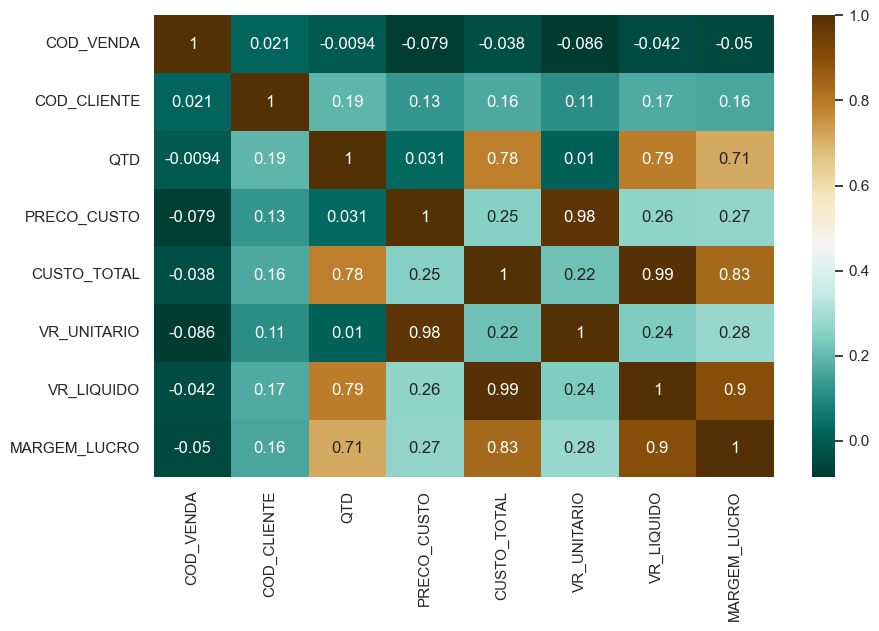

In [31]:
# Heatmap de Correlação
plt.figure(figsize = (10, 6))
sns.heatmap(df_vendas.corr(), annot=True, cmap='BrBG_r');

In [32]:
# Heatmap de Correlação (Spearman)
plt.figure(figsize=(12, 7))
corr = df_vendas.corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.title('Heatmap (Spearman)', fontsize=20)
sns.heatmap(corr, mask=mask, vmax=0.2, center=0, square=True, linewidth=.5, annot=True, cmap='BrBG');

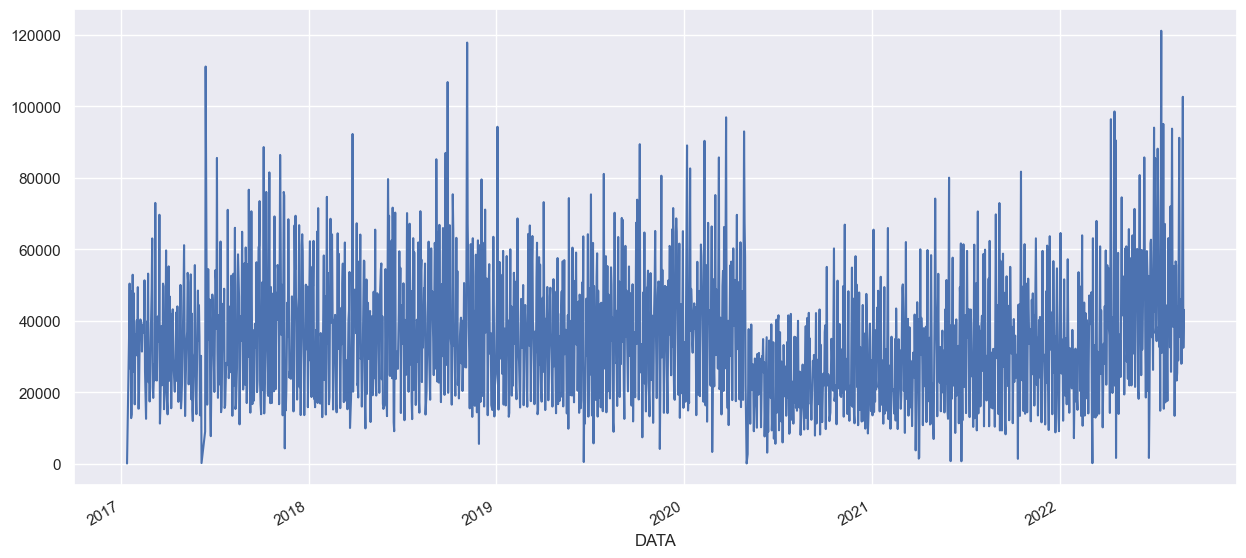

In [33]:
# Grafico de Linhas, Dados Agrupados diario
df = df_vendas.groupby('DATA').VR_LIQUIDO.sum()
plt.figure(figsize=(15, 7))
df.plot();

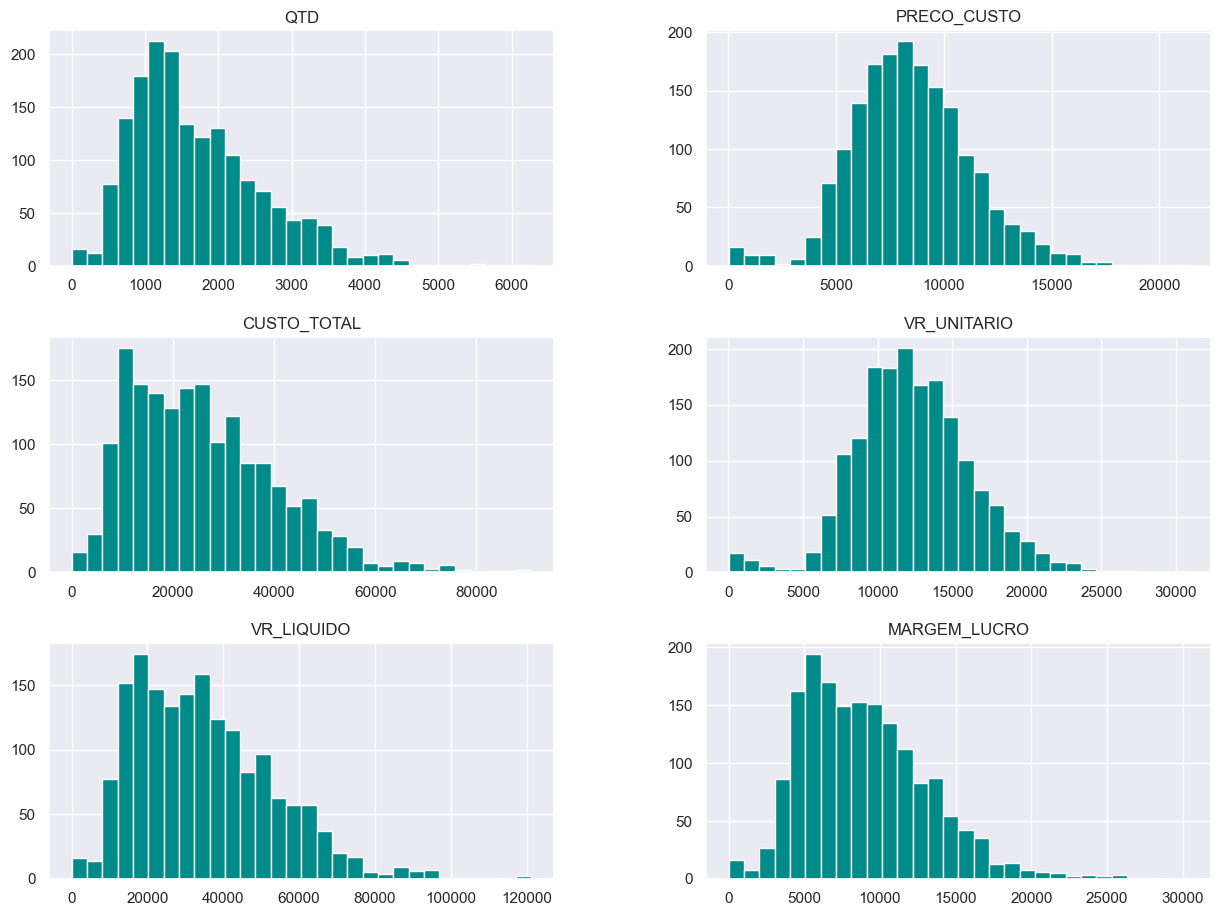

In [34]:
# Histograma apenas das colunas selecionadas, iremos agrupa os dados pelo periodo diario
df = df_vendas.groupby("DATA")[['QTD', 'DATA','PRECO_CUSTO', 'CUSTO_TOTAL', 
                             'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']].sum()
df.hist(figsize=(15, 15), layout=(4,2), color = 'darkcyan', bins=30);

**Criando uma copia do DataFrame**

In [35]:
# Criando uma copia
df_resp = df_vendas.copy()

# Atribuindo a Coluna Data como Index
df_resp.set_index("DATA", inplace=True)

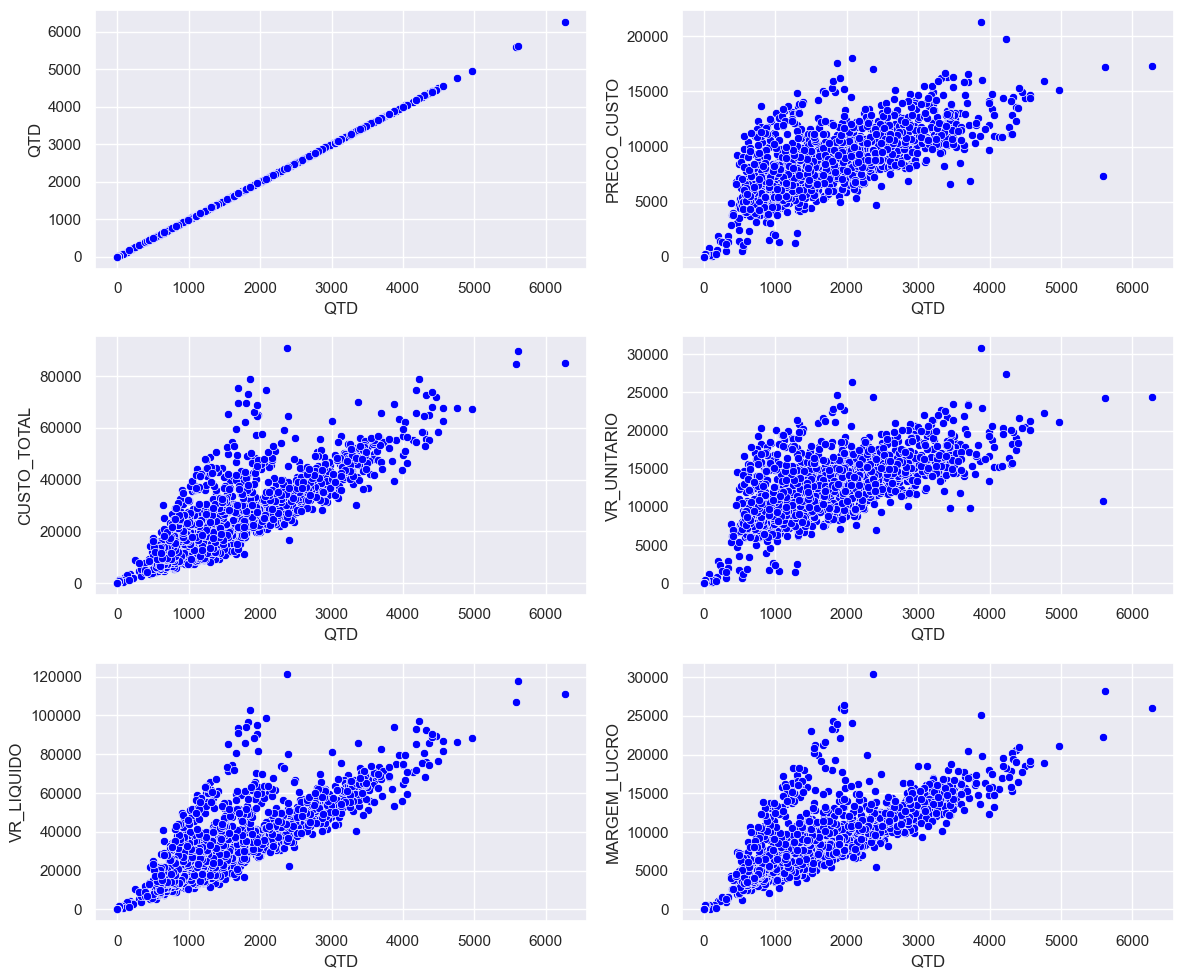

In [36]:
# Analise Grafica. Dispersão da Variavel QTD
df_rp = df_resp.resample('D').sum()
colunas = ['QTD','PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']
plt.figure(figsize=(12,16))
for k in range(len(colunas)):
    plt.subplot(5,2, k+1)
    sns.scatterplot(x='QTD', y=colunas[k], data=df_rp,color='blue')
    plt.ylabel(colunas[k],fontsize=12)
    plt.xlabel('QTD',fontsize=12)
plt.tight_layout();

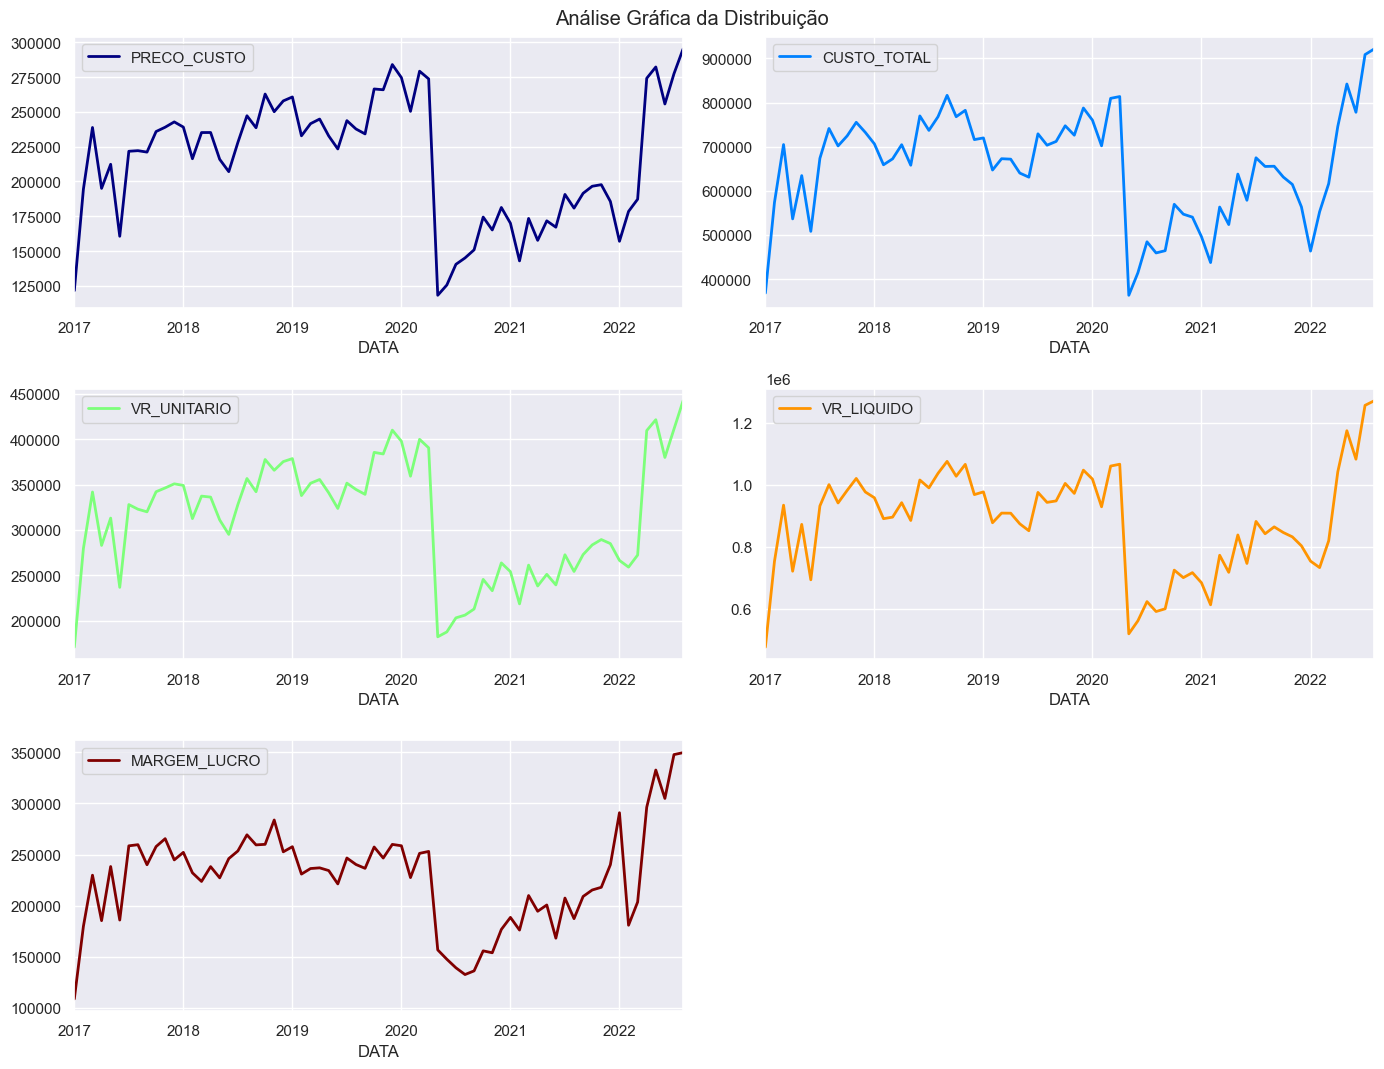

In [37]:
# Analise Grafica: Comportamento dos Dados Periodo Mensal
df = df_resp.resample('M').sum()
df.iloc[:,3:14].plot(subplots=True, layout=(4, 2), figsize=(14, 14), linewidth = 2.0,
                       cmap = 'jet', sharex=False, title = 'Análise Gráfica da Distribuição')
plt.tight_layout();

In [38]:
# Boxplot: Analise de Outliers
df = df_resp[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']]
dados = df.resample("D").sum()
fig = px.box(dados)
fig.show();

In [39]:
# Analisandos os dados de outliers
df = df_vendas[['COD_VENDA', 'COD_CLIENTE', 'COD_VENDEDOR', 'DATA','COD_PRODUTO', 'QTD', 'PRECO_CUSTO', 
                'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'SETOR', 'MUNICIPIO', 'UF', 'MARGEM_LUCRO']].loc[(df_vendas['VR_LIQUIDO'] > 2000)]
df[:4]

COD_VENDA  COD_CLIENTE COD_VENDEDOR       DATA COD_PRODUTO    QTD  \
219005  4198542.0          2.0         51.0 2020-03-12         452  100.0   
219006  4198572.0          2.0         51.0 2020-03-12         452  100.0   
458350  1433312.0          2.0         47.0 2018-02-20           6  100.0   
458351  1434272.0          2.0         47.0 2018-02-20           6  100.0   

        PRECO_CUSTO  CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO    SETOR  \
219005        22.10       2209.9        27.65      2765.0  SETOR 2   
219006        22.10       2209.9        27.65      2765.0  SETOR 2   
458350        21.55       2155.3        30.66      3066.0  SETOR 2   
458351        21.55       2155.3        30.66      3066.0  SETOR 2   

         MUNICIPIO  UF  MARGEM_LUCRO  
219005  JOANOPOLIS  SP         555.1  
219006  JOANOPOLIS  SP         555.1  
458350  JOANOPOLIS  SP         910.7  
458351  JOANOPOLIS  SP         910.7

In [40]:
# Grafico de Linha: Variaveis PRECO_CUSTO, CUSTO_TOTAL, VR_LIQUIDO, MARGEM_LUCRO
db = df_resp.resample('M').sum()
db.reset_index(inplace=True)
fig = px.line(db, x='DATA', y=['PRECO_CUSTO','CUSTO_TOTAL','VR_LIQUIDO','MARGEM_LUCRO'], markers=True, height=600,
             title='Comportamento dos Dados ao Longo do Tempo')
fig.update_traces(textposition="bottom right")
fig.show()

In [41]:
# Plotando várias distribuições bivariadas de pares no nosso conjunto de dados,
df = df_resp[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']]
df_rp = df.groupby('DATA').sum()
sns.pairplot(df_rp, );

In [42]:
df_rp = df_resp.resample('D').sum()
#df_rp = df_vendas.groupby('DATA').sum()
fig = px.scatter(df_rp, x="VR_LIQUIDO", y="VR_UNITARIO", trendline="ols")
fig.show()

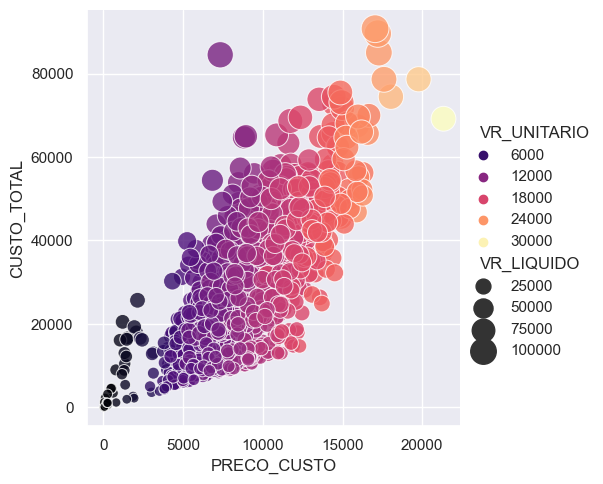

In [43]:
df_rp = df_vendas.groupby('DATA').sum()
sns.relplot(x='PRECO_CUSTO', y='CUSTO_TOTAL', hue='VR_UNITARIO', data=df_rp, size='VR_LIQUIDO',
            sizes=(40,400), alpha=0.8, palette='magma');

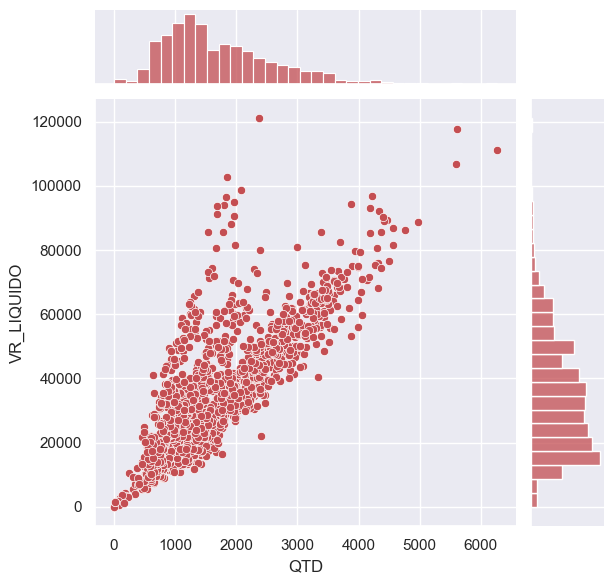

In [44]:
df_rp = df_vendas.groupby('DATA').sum()
sns.jointplot(x='QTD', y='VR_LIQUIDO', color='r', data=df_rp);

In [45]:
df_rp = df_vendas.groupby('DATA').sum()
sns.jointplot(x='CUSTO_TOTAL', y='VR_UNITARIO', data=df_rp);

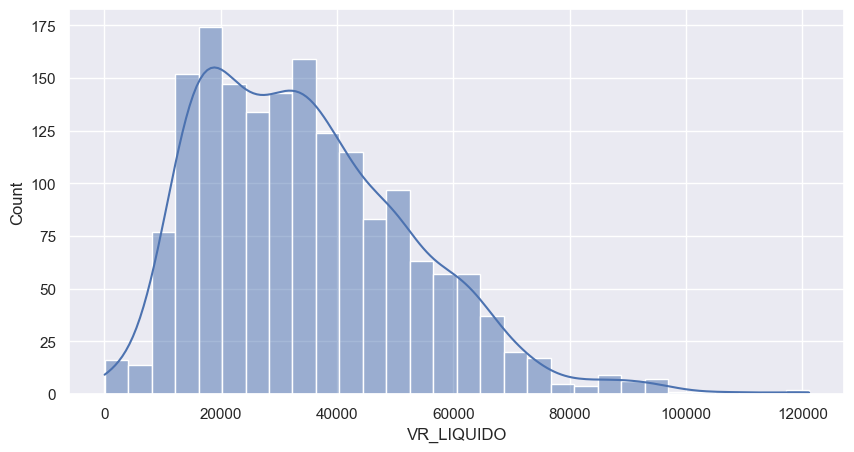

In [46]:
# Distribuição dos dados
plt.figure(figsize=(10,5))
sns.histplot(df_rp.VR_LIQUIDO, bins=30, color='b', kde=True);

# Processamento Final

In [47]:
# Criando uma Nova Variavel ANO_MES
df_vendas['ANO_MES'] = df_vendas['DATA'].apply(lambda x: str(x)[:7])

**Adicionando Algums nomes aleatorios para o Codigo do Vendedor**

In [48]:
# Cabeçalho
df_vendas.head()

COD_VENDA  COD_CLIENTE COD_VENDEDOR       DATA COD_PRODUTO  QTD  \
0   218562.0          2.0       2734.0 2017-03-17       42562  1.0   
1   218632.0          2.0       2734.0 2017-03-17       42562  1.0   
2   809262.0          2.0       3640.0 2017-09-04       59933  1.0   
3   809402.0          2.0       3640.0 2017-09-04       59933  1.0   
4   920012.0          2.0       3640.0 2017-10-04       59933  1.0   

   PRECO_CUSTO  CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO    SETOR   MUNICIPIO  UF  \
0        13.99        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP   
1        13.99        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP   
2        10.84        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP   
3        10.84        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP   
4        10.84        10.84        15.19       15.19  SETOR 2  JOANOPOLIS  SP   

   MARGEM_LUCRO  ANO_MES  
0          0.01  2017-03  
1          0.01  2017-03  
2          0.01  2017-09  
3          0.01  2017-09  
4          4.35  2017-10

# Insights de Negocios

    1. Quais os meses do ano houve mais vendas?
    2. Quais as cidades que mais compram
    3. Como foi as vendas por mês
    4. Quais Vendedores Mais Vendem?
    5. Quais Produtos Mais Vendem?
    6. Quais Produtos Geram maior receita?
    7. Existe Algum cliente que gera maior receita?
    8. As vendas estão crescendo a cada ano?

**1. Quais os meses do ano houve mais vendas?**

In [49]:
# Separando apenas os meses a quantidade e o valor liquido
meses_maior_vendas = df_vendas[['QTD','DATA','ANO_MES','VR_LIQUIDO']].groupby('ANO_MES')[['VR_LIQUIDO','QTD']].sum()
meses = meses_maior_vendas.sort_values(by='VR_LIQUIDO', ascending=False)
meses.reset_index(inplace=True)

In [50]:
# Separando os Meses de Cada Ano
meses_2017 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2017-01') & (meses['ANO_MES'] <= '2017-12')]
meses_2018 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2018-01') & (meses['ANO_MES'] <= '2018-12')]
meses_2019 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2019-01') & (meses['ANO_MES'] <= '2019-12')]
meses_2020 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2020-01') & (meses['ANO_MES'] <= '2020-12')]
meses_2021 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2021-01') & (meses['ANO_MES'] <= '2021-12')]
meses_2022 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2022-01') & (meses['ANO_MES'] <= '2022-12')]

In [51]:
# Selecionando apenas os 4 Maiores meses de vendas de cada ano
meses2017 = meses_2017.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2018 = meses_2018.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2019 = meses_2019.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2020 = meses_2020.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2021 = meses_2021.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2022 = meses_2022.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
total_meses = pd.concat([meses2017, meses2018, meses2019, meses2020, meses2021, meses2022])
len(total_meses)

24

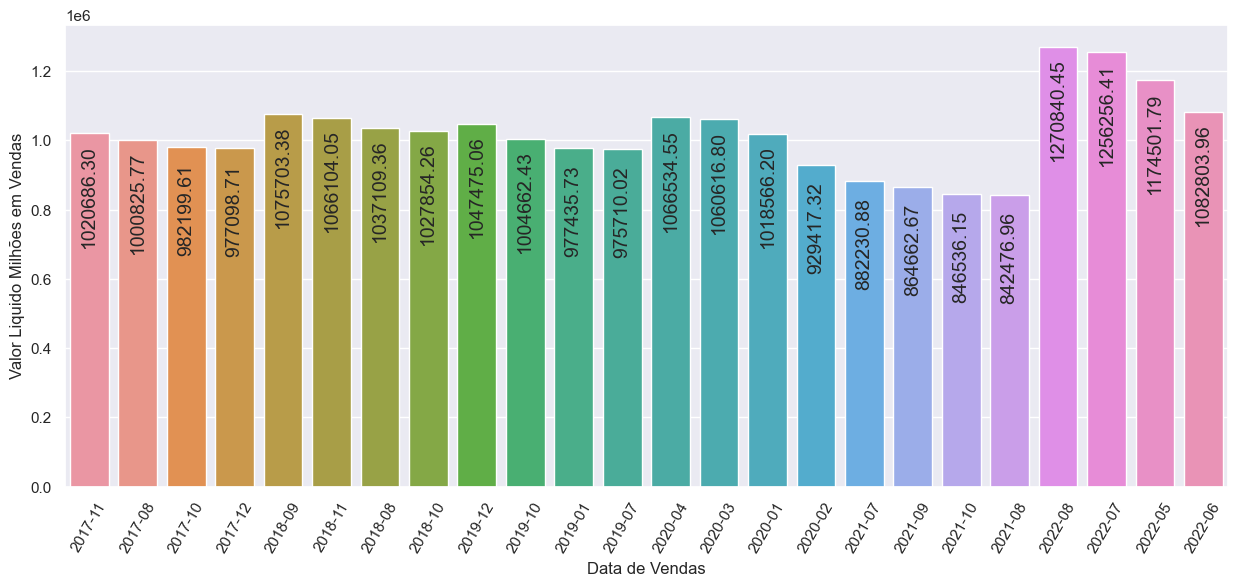

In [52]:
# Maiores Meses onde Ocorreram mais Vendas
#maiores_meses.reset_index(inplace=True)
sns.set(font_scale = 1)
plt.figure(figsize = (15, 6))
plots = sns.barplot(x = 'ANO_MES',  y='VR_LIQUIDO', data=total_meses)
for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center', 
                   size=14, xytext=(0, -45),  textcoords='offset points', rotation=90)
plt.xlabel('Data de Vendas')
plt.ylabel('Valor Liquido Milhões em Vendas')
plt.xticks(rotation = 60);

**2. Quais as cidades que mais compram**

In [53]:
cidades_mais_compram = df_vendas[['QTD','DATA','VR_LIQUIDO','MUNICIPIO',
                                  'UF','ANO_MES']].groupby(['MUNICIPIO','UF'])[['VR_LIQUIDO']].sum()
cidades_mais_compram = cidades_mais_compram.sort_values(by='VR_LIQUIDO', ascending=False)[:15]
cidades_mais_compram.reset_index(inplace=True)
cidades_mais_compram

MUNICIPIO  UF   VR_LIQUIDO
0              JOANOPOLIS  SP  27658158.33
1         NAZARE PAULISTA  SP   4283143.65
2                 EXTREMA  MG   3956020.56
3               SAO PAULO  SP   2942183.99
4               MAIRIPORA  SP   2475943.18
5                 ATIBAIA  SP   2231403.49
6               GUARULHOS  SP   2099725.85
7        FRANCISCO MORATO  SP   1543154.00
8                CAMPINAS  SP   1377501.85
9                 ITATIBA  SP   1203617.77
10               PIRACAIA  SP   1135769.42
11        FRANCO DA ROCHA  SP    774671.20
12        VARZEA PAULISTA  SP    703529.79
13  BOM JESUS DOS PERDOES  SP    603511.64
14            CAMANDUCAIA  MG    574169.94

In [54]:
# Plot grafico
fig = px.bar(cidades_mais_compram, x='MUNICIPIO', y='VR_LIQUIDO', text_auto='.4s',
            title="Cidades que Mais Compram na Empresa", color='VR_LIQUIDO', height=500)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**3. Como foi as vendas por mês**

In [55]:
vendas_mes = df_vendas.groupby('ANO_MES')[['VR_LIQUIDO','QTD','CUSTO_TOTAL','MARGEM_LUCRO']].sum()
vendas_mes.reset_index(inplace=True)
vendas_mes

ANO_MES  VR_LIQUIDO       QTD  CUSTO_TOTAL  MARGEM_LUCRO
0   2017-01   477170.04  25485.00    368336.53     108833.51
1   2017-02   753518.05  43879.00    573723.97     179794.08
2   2017-03   934564.58  53378.00    704766.08     229798.50
3   2017-04   721777.79  44896.00    536413.89     185363.90
4   2017-05   872684.41  52209.00    634416.97     238267.44
..      ...         ...       ...          ...           ...
63  2022-04  1041939.51  24925.18    745725.65     296213.86
64  2022-05  1174501.79  27070.64    841903.88     332597.91
65  2022-06  1082803.96  24383.97    777952.81     304851.15
66  2022-07  1256256.41  28066.94    908566.75     347689.66
67  2022-08  1270840.45  27170.91    921248.65     349591.80

[68 rows x 5 columns]

In [56]:
fig = px.bar(vendas_mes, x='ANO_MES', y=['VR_LIQUIDO','QTD'], color='QTD',
            title='Valor Liquido e Quantidade de Vendas no més', height=500,)
fig.show()

**4. Quais Vendedores Mais Vendem?**

In [57]:
maiores_vendedores = df_vendas[['QTD','COD_VENDEDOR', 'VR_LIQUIDO', 'DATA']]
maiores_vendedores = maiores_vendedores.groupby("COD_VENDEDOR")[['VR_LIQUIDO','QTD']].sum()
maiores_vendedores = maiores_vendedores.sort_values(by='VR_LIQUIDO', ascending=False)[:10]
maiores_vendedores.reset_index(inplace=True)
maiores_vendedores

COD_VENDEDOR   VR_LIQUIDO        QTD
0        248.0  18425407.73  739978.85
1       3640.0   8851932.17  703611.00
2        238.0   3879475.86  147173.00
3         51.0   3366806.30  144184.57
4        498.0   3247280.79  130789.00
5          1.0   2879961.42  185092.92
6         47.0   2750480.42  159163.78
7         52.0   2435307.84   83111.88
8        250.0   1969265.98   88394.00
9         49.0   1468964.97   75834.93

In [58]:
maiores_vendedores.VR_LIQUIDO.sum()

49274883.48

In [59]:
fig = px.bar(maiores_vendedores, x='COD_VENDEDOR', y='VR_LIQUIDO', color='QTD', height=500, text_auto='.4s',
             title='Analise dos Maiores Que mais venderam ao longo do tempo')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**5. Quais Produtos Mais Vendem?**

In [60]:
produtos = df_vendas.groupby('COD_PRODUTO')[['QTD','VR_LIQUIDO']].sum()
produtos = produtos.sort_values('QTD', ascending=False)[:15]
produtos.reset_index(inplace=True)
produtos

COD_PRODUTO       QTD  VR_LIQUIDO
0          452  192945.0  5476729.61
1          456  167474.0  6109886.22
2        51623  138668.0  2897515.84
3        51693  112964.0  2300269.22
4         3340   72437.0   215611.62
5          532   70891.0   684926.10
6         3115   57852.0   154685.37
7         1789   55052.0  1055622.26
8        44150   53602.0   815107.07
9         9261   47751.0   841548.11
10       78323   45981.0   830808.65
11       34661   41228.0   182471.41
12      102733   37784.0  1181064.00
13       37899   27794.0   946260.15
14           6   25443.0   900964.10

In [61]:
print(f'VR_LIQUIDO dos 15 Produtos Mais Vendidos: {produtos.VR_LIQUIDO.sum():.4f}R$')
print(f'VR_LIQUIDO Total de Vendas: {df_vendas.VR_LIQUIDO.sum():.4f}')

VR_LIQUIDO dos 15 Produtos Mais Vendidos: 24593469.7300R$
VR_LIQUIDO Total de Vendas: 60052905.9000


In [62]:
fig = px.bar(produtos, x='COD_PRODUTO', y='QTD', color='QTD', height=500, text_auto='.4s',
             title='Produtos que Mais Vendem')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**6. Quais Produtos Geram maior receita?**

In [63]:
produtos_rc = df_vendas.groupby('COD_PRODUTO')[['COD_PRODUTO','VR_LIQUIDO']].sum()
produtos_maior_rc = produtos_rc.sort_values('VR_LIQUIDO', ascending=False)[:14]
produtos_maior_rc.reset_index(inplace=True)
produtos_maior_rc

COD_PRODUTO  VR_LIQUIDO
0          456  6109886.22
1          452  5476729.61
2        51623  2897515.84
3        51693  2300269.22
4       102733  1181064.00
5         1789  1055622.26
6        37899   946260.15
7            6   900964.10
8         9261   841548.11
9        37900   837760.01
10       78323   830808.65
11       44150   815107.07
12         532   684926.10
13       37913   628894.81

In [64]:
fig = px.bar(produtos_maior_rc, x='COD_PRODUTO', y='VR_LIQUIDO', color='VR_LIQUIDO', height=500, 
             text_auto='.4s', title='Produtos Mais Vendidos que geram maior receita')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

In [65]:
print('15 Produtos de Maior Receita', produtos_maior_rc.VR_LIQUIDO.sum())
print('VR_LIQUIDO', df_vendas.VR_LIQUIDO.sum())

15 Produtos de Maior Receita 25507356.15
VR_LIQUIDO 60052905.90000001


**7. Existe Algum cliente que gera maior receita?**

In [66]:
df_vendas['COD_CLIENTE'] = df_vendas['COD_CLIENTE'].astype('str')
clientes = df_vendas.groupby('COD_CLIENTE')[['QTD','VR_LIQUIDO']].sum()\
                            .sort_values('VR_LIQUIDO', ascending=False)[:15]
clientes.reset_index(inplace=True)
clientes

COD_CLIENTE       QTD   VR_LIQUIDO
0          2.0  976312.6  12593449.86
1       1060.0  119179.0   3070509.63
2        459.0   51778.0   1595961.69
3        517.0   61463.0   1479665.39
4        696.0   68574.0   1386385.59
5        148.0   43844.0   1343809.89
6        206.0   28411.0    748609.60
7        620.0   27001.0    718057.60
8        622.0   31455.0    708568.31
9        700.0   20527.0    677496.70
10       424.0   27133.0    610659.04
11       956.0   20593.0    568519.28
12      1426.0   19150.0    545948.68
13      1653.0   10457.0    456440.23
14       359.0   10199.0    435616.36

In [67]:
fig = px.bar(clientes, x=clientes['COD_CLIENTE'], y='VR_LIQUIDO', color='VR_LIQUIDO', 
             height=500, text_auto='.4s', title='Clientes que geram maior receita')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**8. As vendas estão crescendo a cada ano?**

In [68]:
vendas_ano = df_vendas.groupby(df_vendas['DATA'].dt.year)[['VR_LIQUIDO','QTD']].sum()
vendas_ano.reset_index(inplace=True)
vendas_ano

DATA   VR_LIQUIDO        QTD
0  2017  10308408.80  615891.00
1  2018  11754778.75  668686.00
2  2019  11292169.93  637399.00
3  2020   9116850.59  460850.94
4  2021   9446692.04  344077.04
5  2022   8134005.79  211517.14

In [69]:
fig = px.bar(vendas_ano, x='DATA', y='VR_LIQUIDO', color='QTD',height=500,
            title='Vendas Por Ano', text_auto='.5s')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

Percebemos que ao longo do periodo de 2017 a Abril de 2020 as vendas vinham em uma linha crescente tendo algums picos entre os meses de Junho a Dezembro, porem tivemos um Pico de Queda no més de Maior de 2020, onde no mesmo més foi declarado Lockdown no Brasil COVID-19 https://pt.wikipedia.org/wiki/Lockdown_no_Brasil_em_2021, levando a mais de 8 meses de queda nas vendas. Logo no inicio de Marco 2021, temos começa uma crescente alta nas vendas alcançando seu pico maximo nos méses de Abril a Junho de 2022

# Analise de Séries Temporais:

## **<font color='blue'>Modelos: AUTO_ARIMA, SARIMAX</font>**

In [70]:
# Selecionando apenas as coluna DATA e VR_LIQUIDO e agrupando por periodo diario
dados = df_vendas[['DATA','VR_LIQUIDO']].groupby(['DATA']).sum()
dados.reset_index(inplace=True)
df = dados[['DATA','VR_LIQUIDO']]
print('Utilizando', len(df), 'Valores')

Utilizando 1723 Valores


In [71]:
df_vendas.to_csv("dados_tratados.csv", index=False)

In [72]:
dados_serie = df_vendas[['DATA','VR_LIQUIDO']].groupby(pd.Grouper(key='DATA', freq='6D')).sum()
dados_serie.reset_index(inplace=True)
dados_serie = dados_serie.copy()
dados_serie

DATA  VR_LIQUIDO
0   2017-01-12    86510.78
1   2017-01-18   154256.65
2   2017-01-24   161899.60
3   2017-01-30   184893.20
4   2017-02-05   191166.02
..         ...         ...
338 2022-08-02   227136.41
339 2022-08-08   298876.53
340 2022-08-14   204644.30
341 2022-08-20   242847.71
342 2022-08-26   234208.95

[343 rows x 2 columns]

In [73]:
# Atribuindo a Figura Grafica e Tamanho
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5

## **Análise e Preparação da Série**

### **Criando a Serie**

In [74]:
# Criando a serie
serie = pd.Series(dados_serie['VR_LIQUIDO'].values, index=dados_serie['DATA'].values)
print(serie)
type(serie)

2017-01-12     86510.78
2017-01-18    154256.65
2017-01-24    161899.60
2017-01-30    184893.20
2017-02-05    191166.02
                ...    
2022-08-02    227136.41
2022-08-08    298876.53
2022-08-14    204644.30
2022-08-20    242847.71
2022-08-26    234208.95
Length: 343, dtype: float64


pandas.core.series.Series

In [75]:
# Plot Grafico da Serie
fig = px.line(serie, x=serie.index, y=serie.values, title='Valores Serie Temporal', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### **Média Móvel**

In [76]:
media_movel = serie.rolling(window=5)
media_movel = media_movel.mean()
fig = px.line(media_movel, x=media_movel.index, y=media_movel.values, 
              title='Media Movel 5 Periodos', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [77]:
cores = ['red', 'blue','green']
data = [go.Scatter(x=serie.index, y=serie.values, marker = {'color': cores, 'line': {'color': '#333', 'width': 1}}, 
              opacity=1, name='Valores'),
        go.Scatter(x=media_movel.index, y=media_movel.values, name='Média', 
                   marker = {'color': 'green', 'line': {'color':'#333', 'width':1}}, opacity=0.7)]
# Criando Layout
config_layout = go.Layout(title='Comparação Serie_Real vs Media Movel 5 Periodos', 
                          yaxis={'title':'Valor Liquido'}, xaxis={'title':'Periodo'}, height=600)
# Objeto Figura
fig = go.Figure(data=data, layout=config_layout)
fig.update_xaxes(rangeslider_visible=True)
py.iplot(fig)

**Decomposição dos Dados**

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Analisando os ultimos 500 Periodos
decomposicao = seasonal_decompose(serie[-500:], period=7)

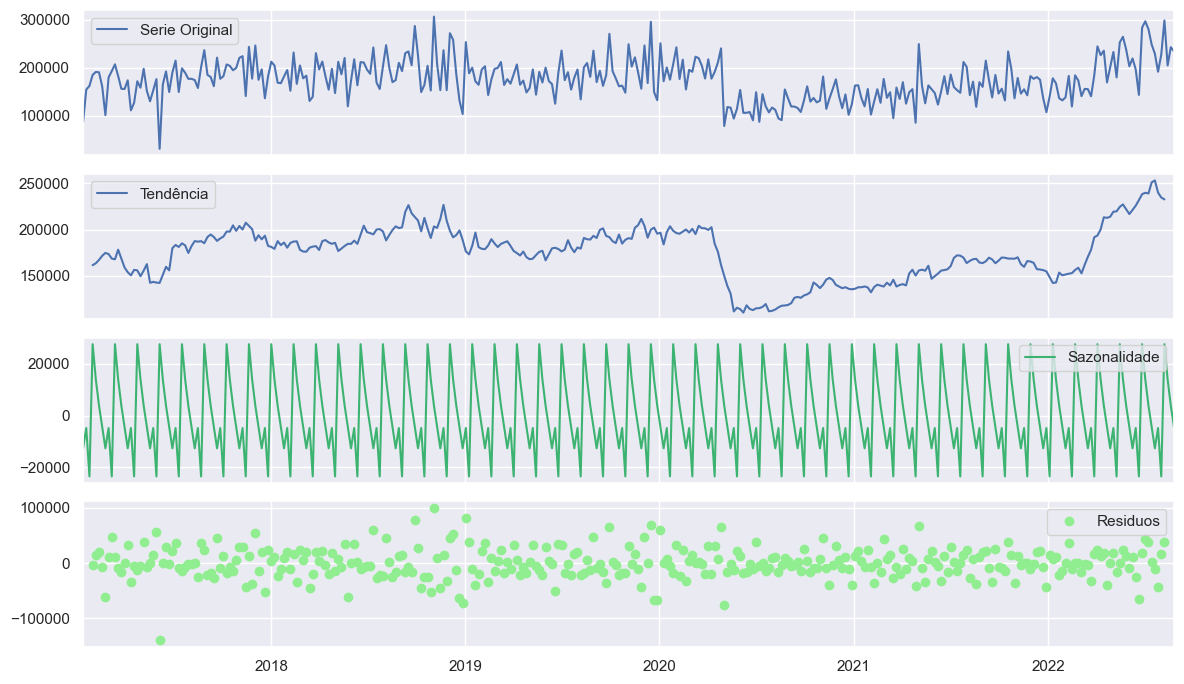

In [79]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 7))
decomposicao.observed.plot(ax=axes[0], legend='best', label='Serie Original')
decomposicao.trend.plot   (ax=axes[1], legend='best', label='Tendência')
decomposicao.seasonal.plot(ax=axes[2], legend='best', label='Sazonalidade', color='mediumseagreen')
decomposicao.resid.plot   (ax=axes[3], legend='best', label='Residuos', color='lightgreen', 
                        marker='o', linewidth=0)
plt.tight_layout();

## **Normalidade e Transformação**

### Normalidade dos dados

In [80]:
import scipy.stats as stats

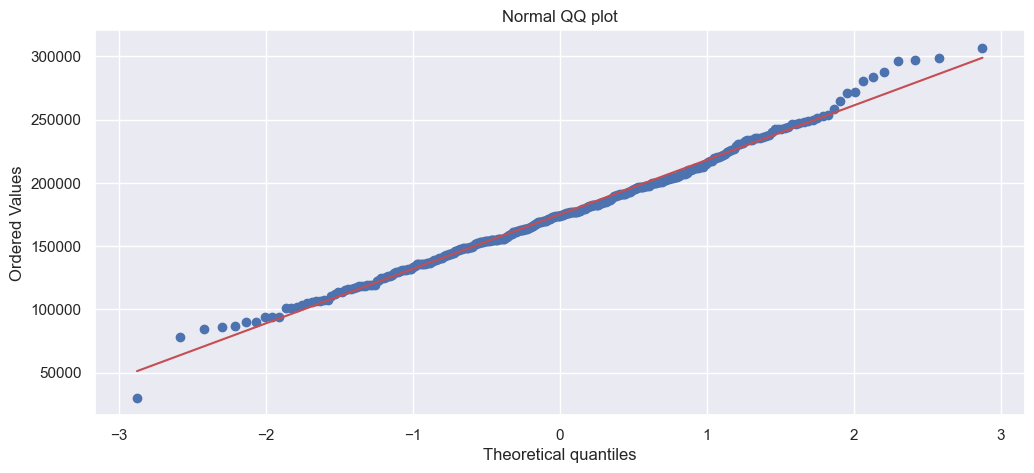

In [81]:
stats.probplot(serie, dist="norm", plot=plt)
plt.title("Normal QQ plot");

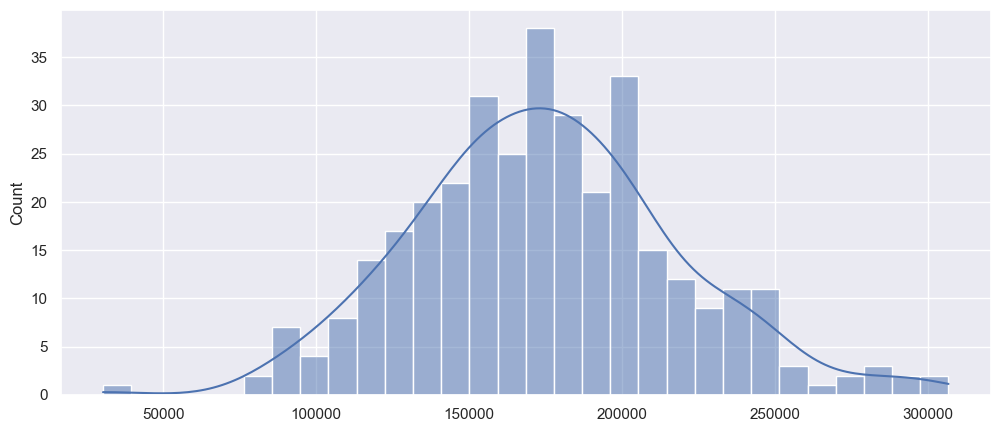

In [82]:
sns.histplot(serie, kde=True, bins=30);

#### TESTE DE SHAPIRO WILK:
    •	Critérios:
    
    Nível de Significância de 0,05 ou 5% (Mais Utilizado)
    Quando P-valor > 0,05 (Temos uma distribuição normal)
    Quando P-valor < 0,05 (Distribuição Não Normal)

In [83]:
e, p = stats.shapiro(serie)
print('Estatística de teste: {:.5f}'.format(e))
print('p-valor: {:.5f}'.format(p))

Estatística de teste: 0.99288
p-valor: 0.10260


### **Teste df (Dickey Fuller)**

    Ho = Não e Estacionario: Estatistica do teste > valor critico
    Ha = E Estacionario: Estatistica do Teste < valor critico

In [84]:
import statsmodels.tsa.stattools

In [85]:
db = statsmodels.tsa.stattools.adfuller(serie)
print(f'Estatistica do teste: {db[0]}')
print(f'P-valor: {db[1]}')
print('Valores criticos: ')
for chave, valor in db[4].items():
    print(f'{chave:<12}: {valor}')

Estatistica do teste: -2.4033025039897136
P-valor: 0.1408064701087834
Valores criticos: 
1%          : -3.450632157720528
5%          : -2.870474482366864
10%         : -2.5715301325443787


### **Transformação por BoxCox**

In [86]:
# Import das Bibliotecas Necessarias
from scipy.special import boxcox, inv_boxcox
from scipy.stats   import boxcox

In [87]:
# Criando e Transformando com Boxcox
serie_box, lam = boxcox(serie.values)
print(f'Lambda: {lam}')

Lambda: 0.7793594990182231


In [88]:
# Visualização da serie e o tipo
print(type(serie_box))
serie_box[:10]

<class 'numpy.ndarray'>


array([ 9035.51846698, 14181.75697424, 14726.49882266, 16332.50928904,
       16762.79837342, 16703.56621399, 14649.42171306, 10182.76677398,
       15965.07088387, 16887.01457091])

In [89]:
# Transformando em Serie
transform = list(serie_box.flatten())
serie_box = pd.Series(transform, index=serie.index)
serie_box

2017-01-12     9035.518467
2017-01-18    14181.756974
2017-01-24    14726.498823
2017-01-30    16332.509289
2017-02-05    16762.798373
                  ...     
2022-08-02    19173.706213
2022-08-08    23747.355721
2022-08-14    17677.004518
2022-08-20    20199.740913
2022-08-26    19637.458255
Length: 343, dtype: float64

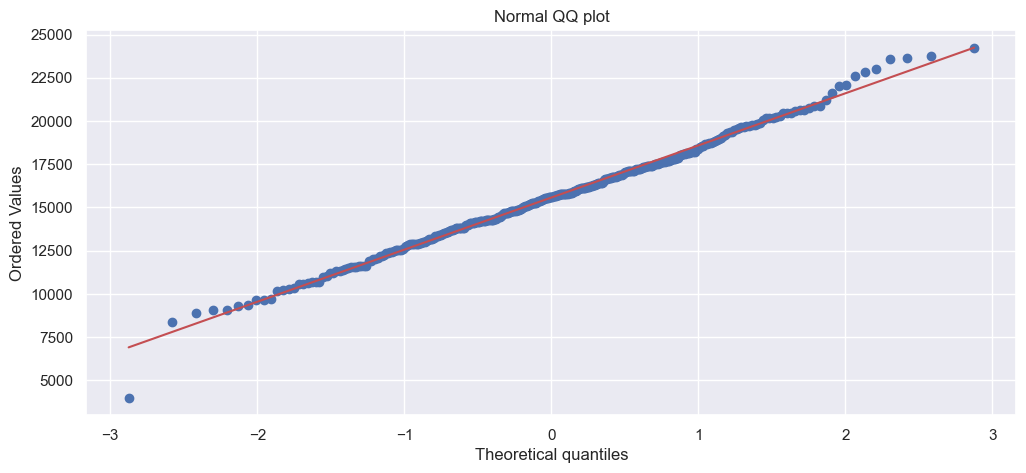

In [90]:
stats.probplot(serie_box, dist="norm", plot=plt)
plt.title("Normal QQ plot");

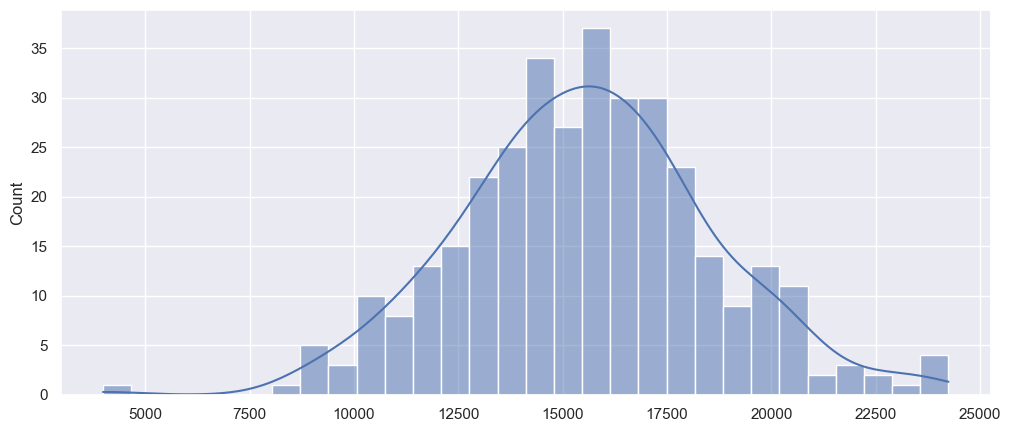

In [91]:
sns.histplot(serie_box, kde=True, bins=30);

#### TESTE DE SHAPIRO WILK:
    •	Critérios:
    
    Nível de Significância de 0,05 ou 5% (Mais Utilizado)
    Quando P-valor > 0,05 (Temos uma distribuição normal)
    Quando P-valor < 0,05 (Distribuição Não Normal)

In [92]:
# TESTE DE SHAPIRO
e, p =stats.shapiro(serie_box)
print('Estatística de teste: {:.7f}'.format(e))
print('p-valor: {:.7f}'.format(p))

Estatística de teste: 0.9950320
p-valor: 0.3389443


### **Teste df (Dickey Fuller)**

    Ho = Não e Estacionario: Estatistica do teste > valor critico
    Ha = E Estacionario: Estatistica do Teste < valor critico

In [93]:
dfb = statsmodels.tsa.stattools.adfuller(serie_box)
print(f'Estatistica do teste: {dfb[0]}')
print(f'P-valor: {dfb[1]}')
print('Valores criticos: ')
for chave, valor in dfb[4].items():
    print(f'{chave:<12}: {valor}')

Estatistica do teste: -2.4211143044348784
P-valor: 0.1358655128483509
Valores criticos: 
1%          : -3.450632157720528
5%          : -2.870474482366864
10%         : -2.5715301325443787


### **Estacionaridade**

### Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

Ho Hipotese Nula = não é estacionário: estatística do teste > valor crítico

Ha Hipotese Alternativa = é estacionário:  estatística do teste < valor crítico

In [94]:
kpss = statsmodels.tsa.stattools.kpss(serie)
print('Estatítica do teste: {:.4f}'.format(kpss[0]))
print('p_valor: {:.4f}'.format(kpss[1]))
print('Valores Críticos:')
for chave, valor in kpss[3].items():
   print(f'{chave:<12}: {valor}')

Estatítica do teste: 0.3682
p_valor: 0.0909
Valores Críticos:
10%         : 0.347
5%          : 0.463
2.5%        : 0.574
1%          : 0.739


In [95]:
kpss = statsmodels.tsa.stattools.kpss(serie_box)
print('Estatítica do teste: {:.4f}'.format(kpss[0]))
print('p_valor: {:.4f}'.format(kpss[1]))
print('Valores Críticos:')
for chave, valor in kpss[3].items():
    print(f'{chave:<12}: {valor}')

Estatítica do teste: 0.3766
p_valor: 0.0872
Valores Críticos:
10%         : 0.347
5%          : 0.463
2.5%        : 0.574
1%          : 0.739


### **Autocorrelação**

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

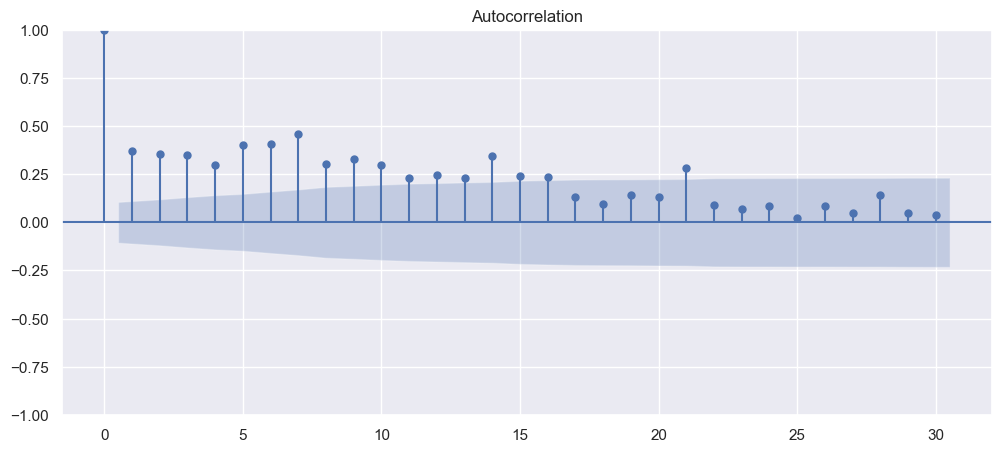

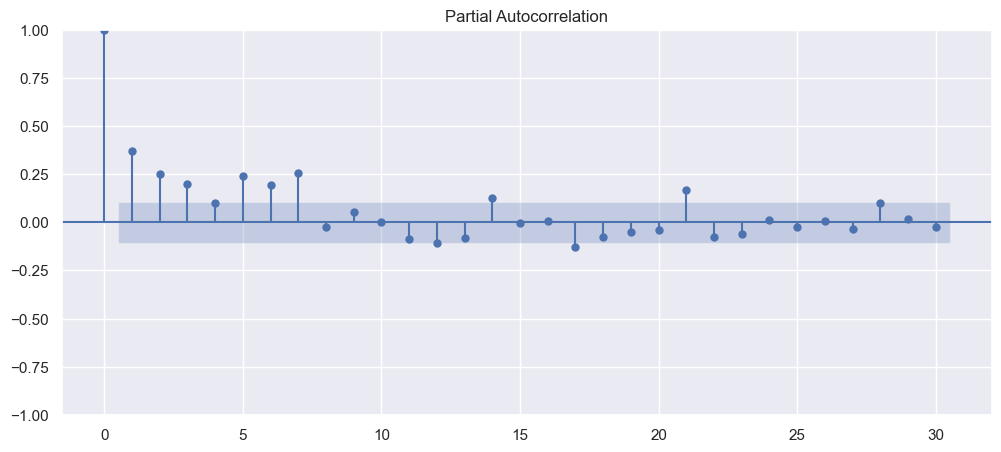

In [97]:
plot_acf(serie_box, lags=30)
plot_pacf(serie_box, lags=30);

## **Seperação Dados de Treino e Teste: SARIMA e SARIMAX**

In [98]:
#70% Treino, 30% Teste
print(f'Shape da Serie: {serie_box.shape}')
treino    = int(len(serie_box) * 0.7)
teste     = int(len(serie_box) - treino)
treino_df = serie_box[:treino]
treino_db = pd.DataFrame(treino_df, columns=['Treino'])
teste_df  = serie_box[-teste:]
teste_db  = pd.DataFrame(teste_df, columns=['Teste'])
print(f'Dados de Treino: {treino_df.shape}')
print(f'Dados te teste: {teste_df.shape}')

Shape da Serie: (343,)
Dados de Treino: (240,)
Dados te teste: (103,)


In [99]:
train_test = pd.concat([treino_db, teste_db])
fig = px.line(train_test, title='Dados de Treino e Teste', height=550)
fig.update_xaxes(rangeslider_visible=False)
fig.show()

## **MODELO AUTO-ARIMA**

#### Modelo Auto-Arima, leva em Consideração a Sazonalidade dos dados

Modelo arima:(p,d,q)

Modelo SARIMA: (p,d,q)(P,D,Q)

In [100]:
# import da biblioteca
from pmdarima.arima import auto_arima

In [101]:
modelo_auto = auto_arima(teste_df, exogenous=treino_df, trace=True, stepwise=False, seasonal=True, max_p=10, max_q=10, max_P=4, 
            max_Q=4, start_p=0, start_q=0, start_P=0, start_Q=0, m=7, d=1, D=1, error_action='ignore',suppress_warnings=True)
print('Resultado AIC = ', modelo_auto.aic())
# Trace: apresenta no console a lista dos modelos.
# stepwise: seleção gradual(processo mais rápido, porém menos minucioso).
# m: período sazonal
# Interessante dobrar as ordens máximas: max.p = 10, max.q = 10, max.P = 4, max.Q = 4

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1814.208, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1773.914, Time=0.27 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,1,3)[7]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,1,4)[7]             : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=1790.649, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(1,1,3)[7]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(1,1,4)[7]             : AIC=inf, Time=3.87 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=1785.517, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(2,1,3)[7]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=1783.831, Time=0.74 sec
 ARIMA(0,1,0)(3,1,1)[7]             : AIC=inf, Time=1.46 sec

In [102]:
#resultado_auto= modelo_auto.fit(teste_df)
print(modelo_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  103
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 7)   Log Likelihood                -865.147
Date:                             Fri, 04 Nov 2022   AIC                           1740.293
Time:                                     08:10:33   BIC                           1753.063
Sample:                                 12-22-2020   HQIC                          1745.453
                                      - 08-26-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6939      0.084     -8.260      0.000      -0.859      -0.529
ma.L2         -0.0217      

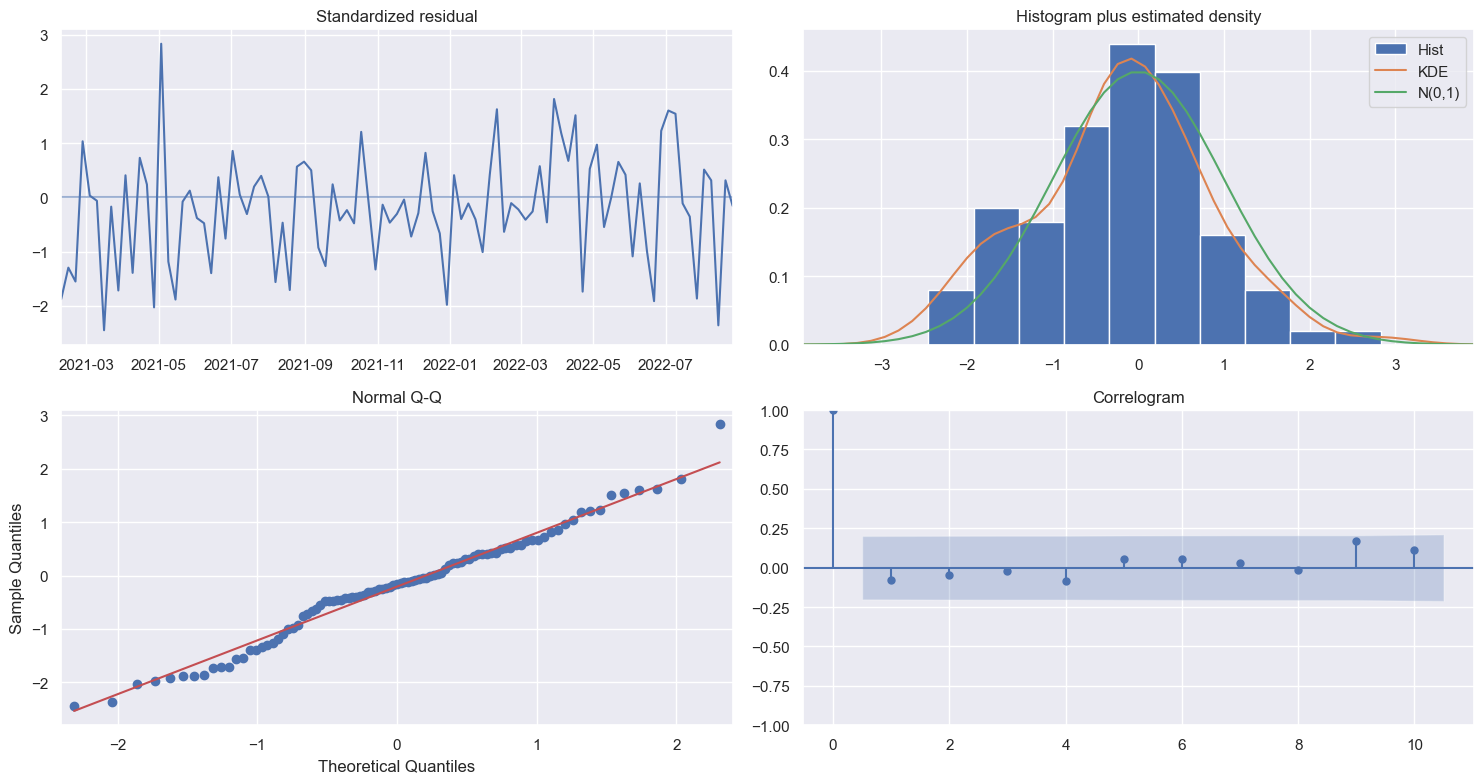

In [103]:
modelo_auto.plot_diagnostics(figsize=(15,8))
plt.tight_layout();

### **Análise dos Resíduos**

In [104]:
# Residuos
residuos_auto = modelo_auto.resid

In [105]:
# TESTE DE SHAPIRO
e, p = stats.shapiro(residuos_auto())
print('Estatística de teste: {:.5f}'.format(e))
print('p-valor: {:.5f}'.format(p))

Estatística de teste: 0.95526
p-valor: 0.00155


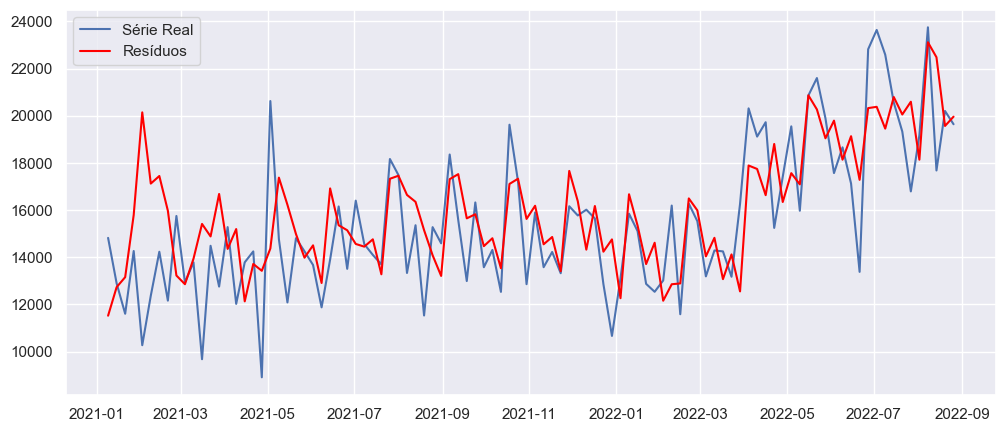

In [106]:
plt.figure(figsize=(12, 5))
plt.plot(serie_box[-100:], label='Série Real')
plt.plot(serie_box[-100:] - residuos_auto(),color='red', label='Resíduos')
plt.legend(loc='best');

### **Previsao SARIMA**

In [107]:
# Prevendo 16 Semanas
previsao_auto = modelo_auto.predict(n_periods=20)
previsao_auto = inv_boxcox(previsao_auto, lam)

# Criando o indice Data
indice = pd.date_range('2022-08-31', periods=len(previsao_auto), freq='6D')

# Criando uma nova serie
aut_arima = pd.Series(previsao_auto.values, index=indice )

In [108]:
# Criando o DataFrame
prev_auto_arima = pd.DataFrame(aut_arima, columns=['SARIMA'])
# Concatenando os dados
prever_auto_arima = pd.concat([serie[-210:], prev_auto_arima])

# Visualização Grafica periodo de 2022
fig = px.line(prever_auto_arima, title='Previsão Proximos 30 Dias com SARIMA', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## **Modelo SARIMAX**

In [109]:
# Import da Biblioteca
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Parametros SARIMA**

    Best model:  ARIMA(0,1,3)(0,1,1)[7]          
    Total fit time: 111.909 seconds
    Resultado AIC =  1740.2932915531403

In [110]:
modelo_sarimax = SARIMAX(teste_df, exogenous=treino_df, order=(0, 1, 3), seasonal_order=(0, 1, 1, 7),
                        enforce_invertibility=False, enforce_stationarity=False)
# Treinando
resultado_sarimax = modelo_sarimax.fit()
# Print do Sumario
print(resultado_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  103
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 7)   Log Likelihood                -757.666
Date:                             Fri, 04 Nov 2022   AIC                           1525.333
Time:                                     08:10:37   BIC                           1537.487
Sample:                                 12-22-2020   HQIC                          1530.219
                                      - 08-26-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9707      0.186    -10.583      0.000      -2.336      -1.606
ma.L2          0.0566      

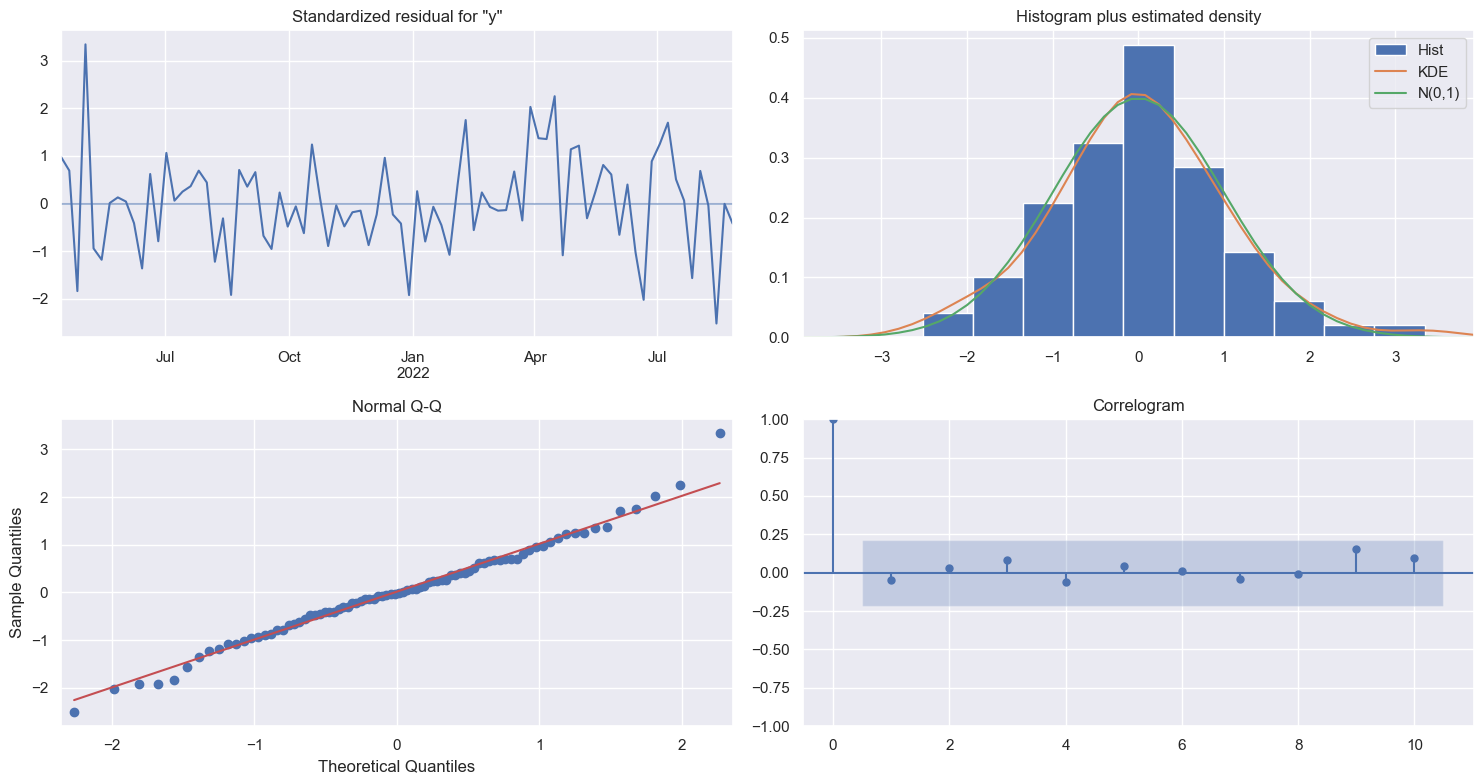

In [111]:
resultado_sarimax.plot_diagnostics(figsize=(15,8))
plt.tight_layout();

### **Análise dos Resíduos**

In [112]:
residuos_sarimax = resultado_sarimax.resid

In [113]:
# TESTE DE SHAPIRO
e, p = stats.shapiro(residuos_sarimax)
print('Estatística de teste: {:.5f}'.format(e))
print('p-valor: {:.5f}'.format(p))

Estatística de teste: 0.94908
p-valor: 0.00059


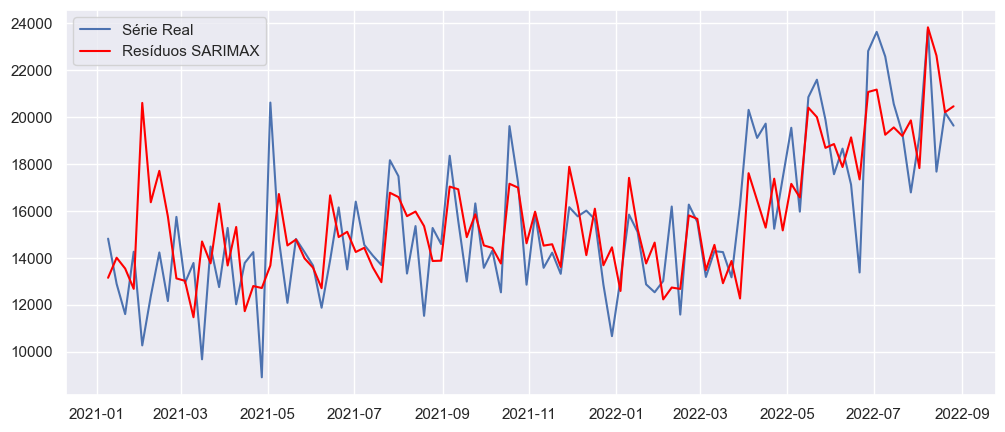

In [114]:
plt.figure(figsize=(12, 5))
plt.plot(serie_box[-100:],  color='b', label='Série Real')
plt.plot(serie_box[-100:] - residuos_sarimax,color='red', label='Resíduos SARIMAX')
plt.legend(loc='best');

### **Previsao com SARIMAX**

In [115]:
# Previsão 16 Semanas
previsao_sarimax = resultado_sarimax.forecast(20)
previsao_sarimax = inv_boxcox(previsao_sarimax, lam)

# Criando o indice Data
indice_sx = pd.date_range('2022-08-31', periods=len(previsao_sarimax), freq='6D')

# Criando uma nova serie
serie_sx = pd.Series(previsao_sarimax.values, index=indice_sx )

In [116]:
# Criando o DataFrame
prev_auto_sarimax = pd.DataFrame(serie_sx, columns=['SARIMAX'])
# Concatenando os dados
prever_sarimax = pd.concat([serie[-210:], prev_auto_sarimax])

# Visualização Graficoa Periodo de 2022
fig = px.line(prever_sarimax, title='Previsão Proximas 20 Semanas com SARIMAX', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# ANALISE DO MELHOR MODELO 

### SARIMA: Leva em consideração a Sazonalidade

                              SARIMAX Results                                      
    ===========================================================================================
    Dep. Variable:                                   y   No. Observations:                  103
    Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 7)   Log Likelihood                -865.147
    Date:                             Thu, 03 Nov 2022   AIC                           1740.293
    Time:                                     21:11:18   BIC                           1753.063
    Sample:                                 12-22-2020   HQIC                          1745.453

### SARIMAX

                               SARIMAX Results                                      
    ===========================================================================================
    Dep. Variable:                                   y   No. Observations:                  103
    Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 7)   Log Likelihood                -757.666
    Date:                             Thu, 03 Nov 2022   AIC                           1525.333
    Time:                                     21:12:03   BIC                           1537.487
    Sample:                                 12-22-2020   HQIC                          1530.219

# **Análise Final do Projeto**

    ANALISE DO MELHOR MODELO SARIMAX
    COMPARAÇÃO COM PERIODOS ANTERIORES E DESEMPENHO

In [117]:
# Utilizando 8 Semanas periodos para Analise e Desempenho do Modelo
valores = 8
previsao_passada = resultado_sarimax.predict(len(teste_df)- len(teste_df[-valores:])+1, end=len(teste_df))
previsao_futura  = resultado_sarimax.forecast(valores)
deste_box        = serie_box[-valores:].values

In [118]:
auto_arima    = modelo_auto.predict(n_periods=valores)
previsao_auto = inv_boxcox(auto_arima, lam)

In [119]:
indice_sx = pd.date_range('2022-07-05', periods=len(previsao_futura), freq='6D')

In [120]:
so = []
dados = pd.DataFrame(so)
dados['Data']            = indice_sx.values
dados['Valores_Reais']   = deste_box
dados['Modelo_Sarimax']  = previsao_passada.values
dados['Previsao_Futura'] = previsao_futura.values
dados['Auto_ARIMA']      = auto_arima.values
dados[:5]

Data  Valores_Reais  Modelo_Sarimax  Previsao_Futura    Auto_ARIMA
0 2022-07-05   20561.141455    19199.107404     18905.269139  18566.159686
1 2022-07-11   19323.996158    19862.168099     18832.334904  18860.701818
2 2022-07-17   16790.021459    17827.465022     17921.636285  17870.988002
3 2022-07-23   19173.706213    23830.216158     22931.816293  22499.005696
4 2022-07-29   23747.355721    22621.762548     21513.585420  21507.949958

In [121]:
serie_real   = inv_boxcox(deste_box, lam) 
serie_real   = list(serie_real.flatten())

In [122]:
# Dados com a transformação por BoxCox
previsao_p   = inv_boxcox(previsao_passada, lam)
previsao_f   = inv_boxcox(previsao_futura, lam)
# Criando o DataFrame
ab = []
df_real = pd.DataFrame(ab)
df_real['DATA']       = indice_sx.values
df_real['Valores_R']  = serie_real
df_real['Previsao_F'] = previsao_f.values
df_real['Previsao_P'] = previsao_p.values
df_real['P_Auto_arima'] = previsao_auto.values

In [123]:
df_real = df_real.round(2)
df_real[:5]

DATA  Valores_R  Previsao_F  Previsao_P  P_Auto_arima
0 2022-07-05  248436.34   223064.56   227522.55     217944.07
1 2022-07-11  229423.19   221961.05   237653.04     222390.11
2 2022-07-17  191564.43   208284.97   206881.82     207530.05
3 2022-07-23  227136.41   285771.85   300215.21     278870.25
4 2022-07-29  298876.53   263297.40   280823.95     263208.92

### AVALIAÇÃO DOS ERROS DO MODELO PARA FINS DE ANALISE DE DESEMPENHO

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

### Avaliação dos Erros Com Dados REVERTIDA A Transformação com BoxCox

In [125]:
print(f'{"*"*33}\33[33;4m{"AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM PREVISÃO FUTURA"}\33[0m{"*"*33}')
mae_sarimax =  mean_absolute_error(df_real['Valores_R'], df_real['Previsao_F'])
print(f'(MAE) Erro Médio Absoluto: {mae_sarimax:.3f}')
mse_sarimax =  mean_squared_error(df_real['Valores_R'],  df_real['Previsao_F'])
print(f'(MSE) Erro Quadrático Médio: {mse_sarimax:.3f}')
rmse_sarimax = mean_squared_error(df_real['Valores_R'],  df_real['Previsao_F'], squared=False)
print(f'(RMSE) Raiz do Erro Quadrático Médio: {rmse_sarimax:.3f}')
mape_sarimax = mean_absolute_percentage_error(df_real['Valores_R'],  df_real['Previsao_F'])
print(f"(MAPE) Erro Percentual Absoluto Médio: {(mape_sarimax) * 100:.3F}")
print(f'{"-"*125}')

*********************************AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM PREVISÃO FUTURA*********************************
(MAE) Erro Médio Absoluto: 24104.881
(MSE) Erro Quadrático Médio: 982657120.333
(RMSE) Raiz do Erro Quadrático Médio: 31347.362
(MAPE) Erro Percentual Absoluto Médio: 10.466
-----------------------------------------------------------------------------------------------------------------------------


In [126]:
print(f'{"*"*33}\33[33;4m{"AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM DADOS PASSADOS"}\33[0m{"*"*33}')
mae_sarimax =  mean_absolute_error(df_real['Valores_R'], df_real['Previsao_P'])
print(f'(MAE) Erro Médio Absoluto: {mae_sarimax:.3f}')
mse_sarimax =  mean_squared_error(df_real['Valores_R'],  df_real['Previsao_P'])
print(f'(MSE) Erro Quadrático Médio: {mse_sarimax:.3f}')
rmse_sarimax = mean_squared_error(df_real['Valores_R'],  df_real['Previsao_P'], squared=False)
print(f'(RMSE) Raiz do Erro Quadrático Médio: {rmse_sarimax:.3f}')
mape_sarimax = mean_absolute_percentage_error(df_real['Valores_R'],  df_real['Previsao_P'])
print(f"(MAPE) Erro Percentual Absoluto Médio: {(mape_sarimax) * 100:.3F}")
print(f'{"-"*125}')

*********************************AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM DADOS PASSADOS*********************************
(MAE) Erro Médio Absoluto: 23642.430
(MSE) Erro Quadrático Médio: 1002171497.017
(RMSE) Raiz do Erro Quadrático Médio: 31657.092
(MAPE) Erro Percentual Absoluto Médio: 10.423
-----------------------------------------------------------------------------------------------------------------------------


### Fazendo Previsão Para os Proximos Meses

In [127]:
# Previsão Para os Proximos 4 Meses
previsao_sarimax = resultado_sarimax.forecast(21)
previsao_sarimax = inv_boxcox(previsao_sarimax, lam)
# Criando o indice Data
indice_sx = pd.date_range('2022-08-31', periods=len(previsao_sarimax), freq='6D')
# Criando uma nova serie
serie_sx = pd.Series(previsao_sarimax.values, index=indice_sx )
serie_sx2 = pd.DataFrame(serie_sx)

In [128]:
# Trazendos Os Dados Copiados no inicio do Projeto
df = dados_serie[['DATA','VR_LIQUIDO']]
df = pd.Series(df['VR_LIQUIDO'].values, index=df['DATA'].values)

In [129]:
dados_concat = pd.concat([df, serie_sx2])
dados_concat.reset_index(inplace=True)
dados_concat = dados_concat.rename(columns={'index':'DATA', 0:'VR_LIQUIDO'})
dados_concat['ANO_MES'] = dados_concat['DATA'].apply(lambda x: str(x)[:7])

## Grafico Previsao Proximos 4 Meses

In [130]:
teste = dados_concat.groupby('ANO_MES').sum()
teste.reset_index(inplace=True)
fig = px.bar(teste[45:], x='ANO_MES', y='VR_LIQUIDO', color='VR_LIQUIDO',
            title='Grafico Com os Proximos 4 Meses de Previsão', height=600,)
fig.update_xaxes(rangeslider_visible=True)
fig.show()